In [57]:
# Importing the required libraries
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import Callback
import numpy as np
import matplotlib.pyplot as plt
# Setting the random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Defining the batch size, available GPUs, and number of workers
BATCH_SIZE=32
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

This block of code imports various libraries required for building a deep learning model using PyTorch. It also sets the random seed to 42 for reproducibility of results.

Furthermore, it defines the batch size for the data loader, the number of available GPUs, and the number of workers for the data loader to use.
***

In [58]:
torch.cuda.is_available()

True

In [59]:
# Define CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.FFT_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.FFT_files)

    def __getitem__(self, idx):
        file_name=self.FFT_files[idx]
        FFT_path = os.path.join(self.root_dir, file_name)
        FFT = (10**7)*pd.read_csv(FFT_path,header=None).values
        FFT_tensor = torch.tensor(FFT, dtype=torch.float32)
        FFT_tensor = FFT_tensor.view(-1, FFT_tensor.shape[1])
        Label_Tag=file_name.split('_')
        label=[]
        for n in [1,3,5,7,9,11,13]:
            temp_num=float(Label_Tag[n])
            label.append(temp_num)
        label=torch.tensor(label)
    
        return FFT_tensor, label

In [60]:
## Converting the 2D data matrix to a 3D matrix

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, csv_root, transform=None, batch_size=32, num_workers=0):
        super().__init__()
        self.csv_root = csv_root   # Directory path where the CSV file is stored
        self.batch_size = batch_size   # The batch size for the data loader
        self.num_workers = num_workers   # The number of worker processes for loading the data
        self.transform = transform   # Optional data transformation to be applied

    def prepare_data(self):
        pass   # Placeholder for any data preparation step, if needed

    def setup(self, stage=None):
        self.dataset = CustomDataset(self.csv_root, transform=self.transform)   # Initialize the CustomDataset class with the specified CSV directory and transform
        #self.dataset_train, self.dataset_val = random_split(self.dataset,[int(len(self.dataset)*0.7),len(self.dataset)-int(len(self.dataset)*0.7)])
        self.dataset_train = self.dataset   # Set the training dataset to be the entire dataset

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)   # Return a DataLoader object for the training data, which shuffles the data and divides it into batches

    def val_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)   # Return a DataLoader object for the validation data, which is set to be the same as the training data

    def test_dataloader(self):
        return None   # No test data is used for this model, so return None


In [61]:
# Setting the root directory of the dataset
root_dir = '../Data/FFT_Data/Turn_off'

# Defining the transformations for the dataset using PyTorch's Compose function
# transformations = transforms.Compose([
#     transforms.ToTensor(),
# ])

# Creating a custom dataset and dataloader using the CustomDataModule class
data_module = CustomDataModule(root_dir, transform=None)

In [62]:
# Set up the data module and data loader
data_module.setup()

# Retrieve the training data from the data loader
train_dataloader = data_module.train_dataloader()

# Get the first batch of data from the data loader
i, l = next(iter(train_dataloader))

In [63]:
# Printing the shape of the input data and labels
print(i.shape)
print(l.shape)

torch.Size([32, 3, 981])
torch.Size([32, 7])


### Discriminator



In [64]:
# A discriminator model that determines if an image is real or fake, outputting a single value between 0 and 1

## TODO: Change the Channel and input size

# Start [batch, 3, 981] using 1-D Convolution, and using dialation for using data diffenrent part data 
# [batch, 3, 981] > [batch, 3, 979] > [batch, 3, 975] > [batch, 3, 967] > [batch, 3, 951] > [batch, 3, 919] > [batch, 3, 855] > [batch, 3, 727] > [batch, 3, 471] <[batch, 1, 469] 
# linear [469, 200, 1]
#  
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN architecture with dialation  references by TCN
        self.conv1 = nn.Conv1d(3, 3, kernel_size=3,dilation=1)
        self.conv2 = nn.Conv1d(3, 3, kernel_size=3,dilation=2)
        self.conv3 = nn.Conv1d(3, 3, kernel_size=3,dilation=4)
        self.conv4 = nn.Conv1d(3, 3, kernel_size=3,dilation=8)
        self.conv5 = nn.Conv1d(3, 3, kernel_size=3,dilation=16)
        self.conv6 = nn.Conv1d(3, 3, kernel_size=3,dilation=32)
        self.conv7 = nn.Conv1d(3, 3, kernel_size=3,dilation=64)
        self.conv8 = nn.Conv1d(3, 3, kernel_size=3,dilation=128)
        self.conv9 = nn.Conv1d(3, 1, kernel_size=3)

        # FCN
        self.fc1 = nn.Linear(469, 200)
        self.fc2 = nn.Linear(200, 1)

        
  
    def forward(self, x):
        # Apply convolutional and ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        # Flatten the tensor so it can be fed into the fully connected layers
        temp_length=x.shape[2]
        x = x.view(-1, temp_length)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        # Apply sigmoid activation to output a value between 0 and 1
        return torch.sigmoid(x)

### Generator

In [65]:
## A generator model that takes a latent space vector as input and outputs a wavelet image

## TODO: 
# Input_size [batch,7]
# End_size [batch, 3, 981]

# size history [7] > [64] > [488] [3,490] > [3, 981]
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers of the generator
        self.lin1 = nn.Linear(7, 64)
        self.lin2 = nn.Linear(64, 128) 
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256, 488)
        self.lin5 = nn.Linear(488, 981)
        self.lin6 = nn.Linear(981, 981 *3)
    

    def forward(self, x):
        # Pass the input through a linear layer and reshape
        batch_size=x.shape[0]
        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)
        x = F.relu(x)

        x = self.lin4(x)
        x = F.relu(x)

        x = self.lin5(x)
        x = F.relu(x)

        x = self.lin6(x)

        x=x.view(batch_size,3,-1)      

        return x

### GAN

In [46]:
## TODO: Change the input Data using the label

class GAN(pl.LightningModule):
    def __init__(self,Result_path,lr=0.0002):
        super().__init__()
        # Save the hyperparameters and initialize the generator and discriminator
        self.automatic_optimization=False
        self.save_hyperparameters()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.save_result_path=Result_path
        
    def forward(self, z):
        return self.generator(z)
    
    def adverarial_loss(self, y_hat,y):
        # Calculate binary cross-entropy loss
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        g_opt, d_opt = self.optimizers()
        real_data, labels = batch
        self.for_result=labels
        self.Original = real_data
        z = labels
        z = z.type_as(real_data)
        
        # Train the generator: maximize log(D(G(z)))
        generate_data = self(z)
        y_hat = self.discriminator(generate_data)
        
        y = torch.ones(real_data.size(0), 1)
        y = y.type_as(real_data)
        
        g_loss = self.adverarial_loss(y_hat, y)
        
        g_opt.zero_grad()
        self.manual_backward(g_loss)
        g_opt.step()
        log_dict = {"g_loss" : g_loss }
    
        # Train the discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        y_hat_real = self.discriminator(real_data)
        y_real = torch.ones(real_data.size(0), 1)
        y_real = y_real.type_as(real_data)
        real_loss = self.adverarial_loss(y_hat_real, y_real)
        
        y_hat_fake = self.discriminator(self(z))
        y_fake = torch.zeros(real_data.size(0), 1)
        y_fake = y_fake.type_as(real_data)
        fake_loss = self.adverarial_loss(y_hat_fake, y_fake)
        
        d_loss = (real_loss + fake_loss) / 2
        
        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()
        log_dict = {"d_loss" : d_loss }
        return {"d_loss": d_loss,"g_loss":g_loss, "progress bar" : log_dict, "log": log_dict}
                
    def configure_optimizers(self):
        lr=self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return opt_g, opt_d
    
    
    def on_train_end(self):
        z=self.for_result.type_as(self.generator.lin1.weight)
        z=self(z)
        Result=z.cpu().detach().numpy()
        batch=Result.shape[0]
        Result=Result.reshape(batch * 3 , -1)
        Result= pd.DataFrame(Result,index=None)
        save_result= self.save_result_path + 'Result.csv'
        Result.to_csv(save_result,header=False,index=False)
        Original_data = self.Original.cpu().detach().numpy()
        Original_data = Original_data.reshape(batch * 3 , -1)
        Original_data= pd.DataFrame(Original_data,index= None)
        Original_data_path = self.save_result_path + 'Original.csv'
        Original_data.to_csv(Original_data_path,header=False,index=False)

        
    def on_train_epoch_end(self):
        z=self.for_result.type_as(self.generator.lin1.weight)
        Result=self.Original.cpu().detach().numpy()
        z=self(z)
        z=z.cpu().detach().numpy()
        fig, axes = plt.subplots(3,2,sharex=True)
        axes[0,0].plot(z[0,0,:])
        axes[1,0].plot(z[0,1,:])
        axes[2,0].plot(z[0,2,:])
        axes[0,1].plot(Result[0,0,:])
        axes[1,1].plot(Result[0,1,:])
        axes[2,1].plot(Result[0,2,:])

        plt.show()


        print('epoch',self.current_epoch)

In [66]:
# Setting the root directory of the dataset
root_dir = '../Data/FFT_Data/Turn_off'

# Creating a custom dataset and dataloader using the CustomDataModule class
data_module = CustomDataModule(root_dir, transform=None)
# Create an instance of the GAN model
save_result_path="../Data/Gan_Data/FFT/"
model = GAN(Result_path=save_result_path)
# Set up the trainer object

trainer = pl.Trainer(max_epochs=300)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\Users\SMEET_SIMUL\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3.5 M 
1 | discriminator | Discriminator | 94.5 K
------------------------------------------------
3.6 M     Trainable params
0         Non-traina

Epoch 0: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s, v_num=15]

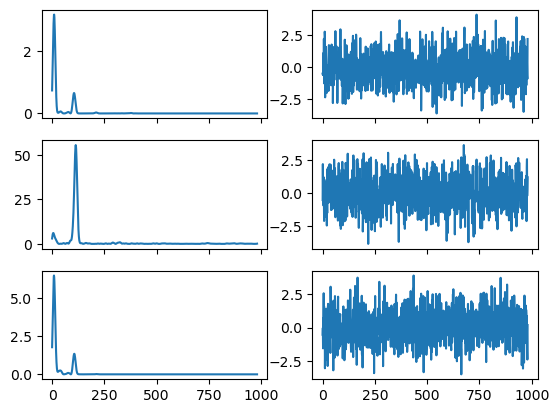

epoch 0
Epoch 1: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

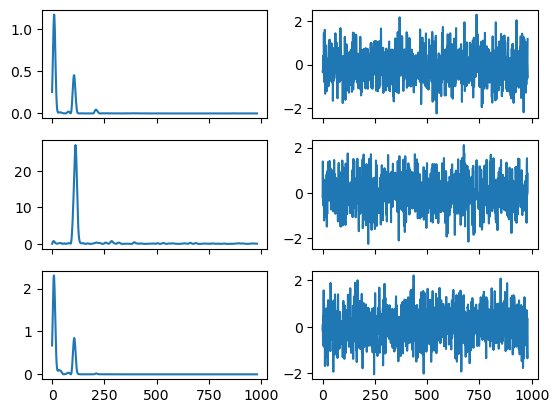

epoch 1
Epoch 2: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

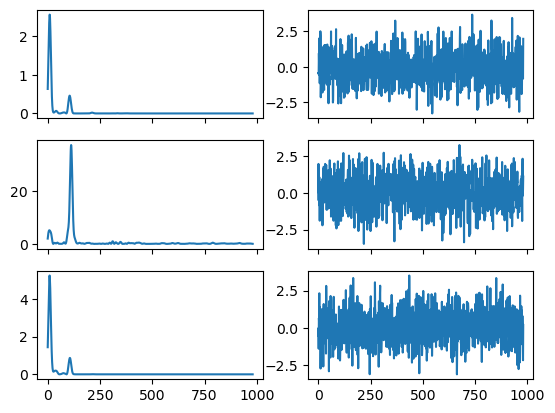

epoch 2
Epoch 3: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

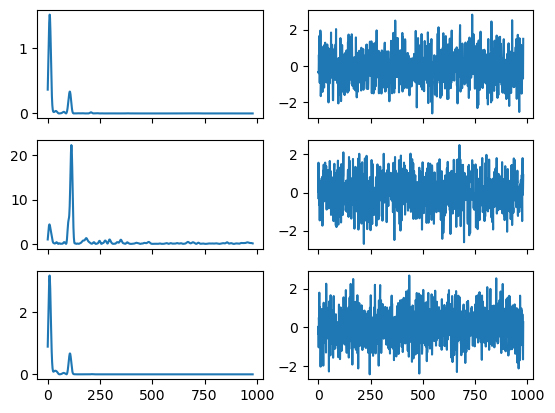

epoch 3
Epoch 4: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

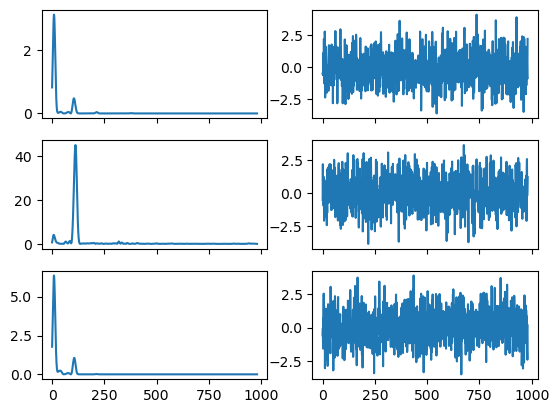

epoch 4
Epoch 5: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

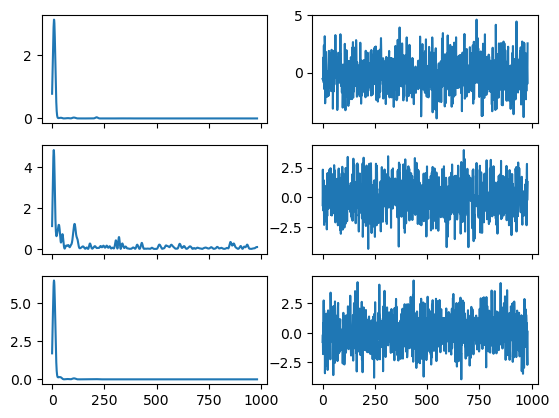

epoch 5
Epoch 6: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

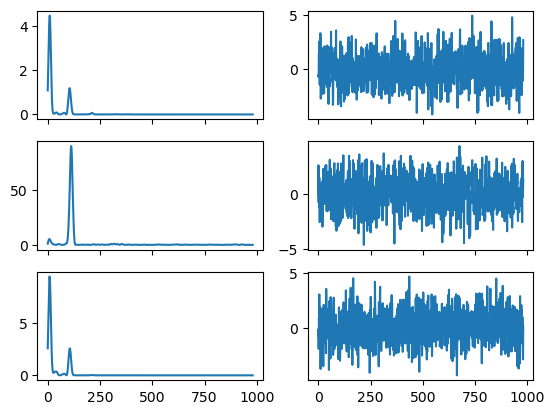

epoch 6
Epoch 7: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

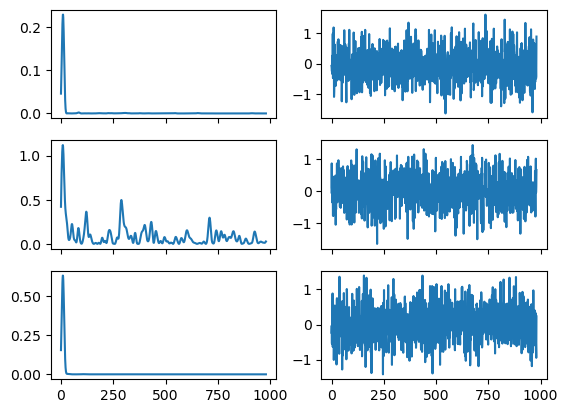

epoch 7
Epoch 8: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

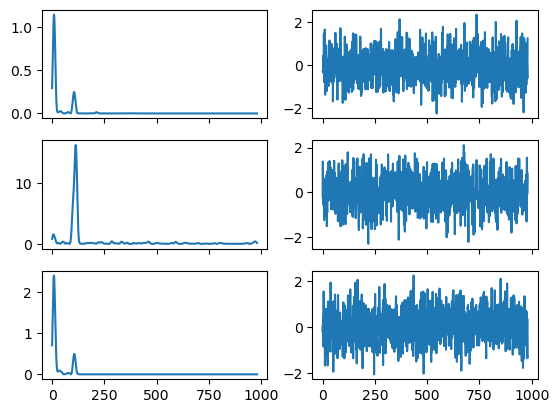

epoch 8
Epoch 9: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

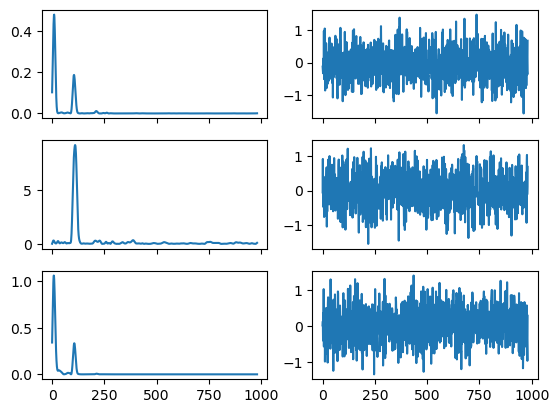

epoch 9
Epoch 10: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

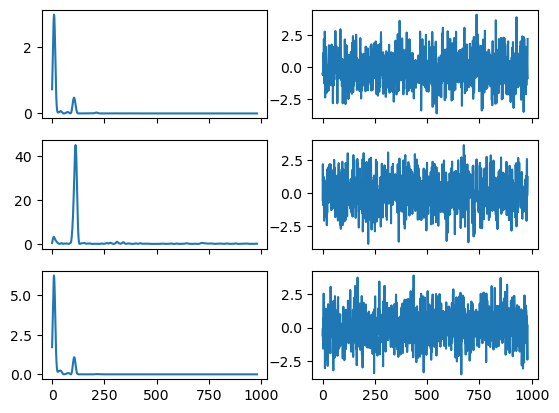

epoch 10
Epoch 11: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

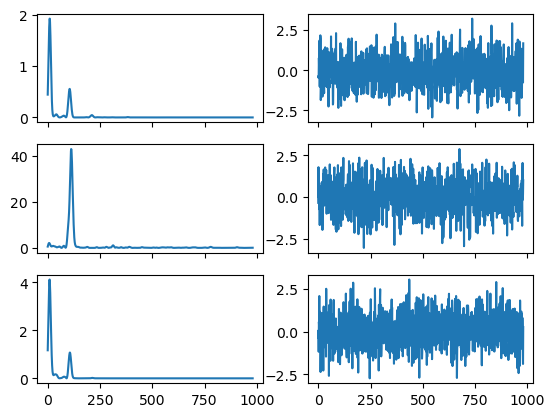

epoch 11
Epoch 12: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

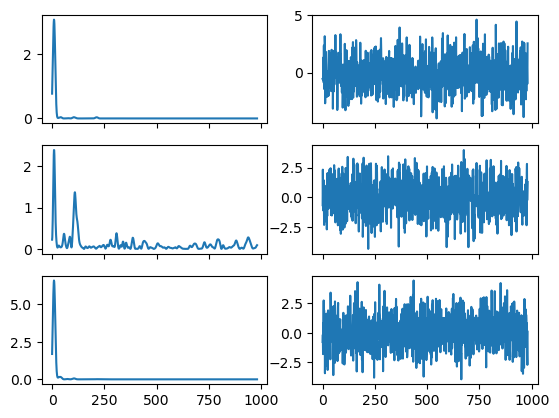

epoch 12
Epoch 13: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

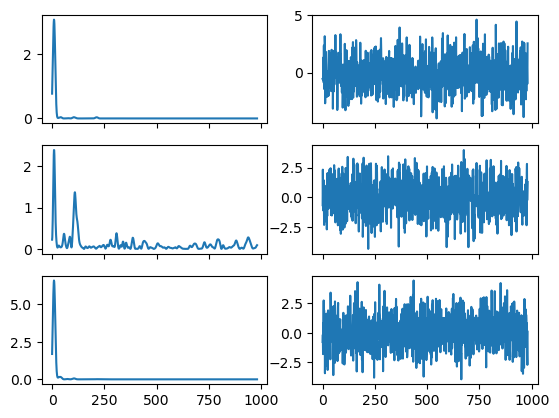

epoch 13
Epoch 14: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

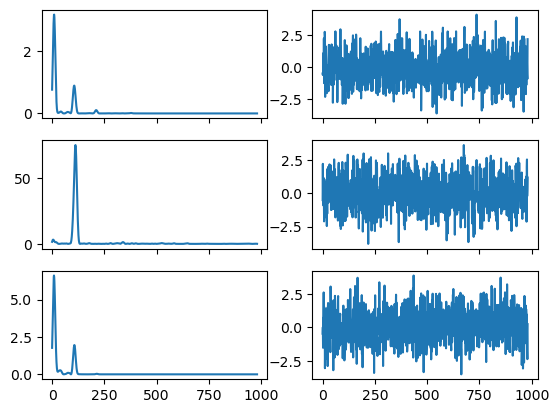

epoch 14
Epoch 15: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

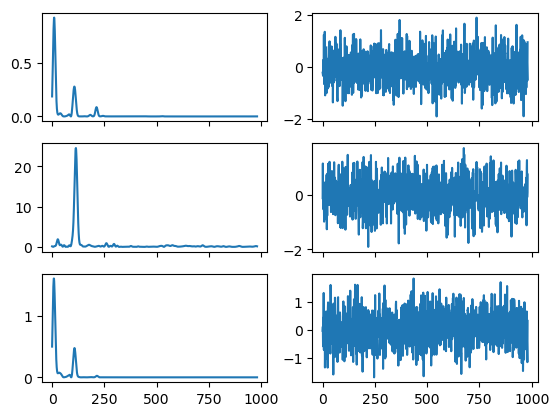

epoch 15
Epoch 16: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

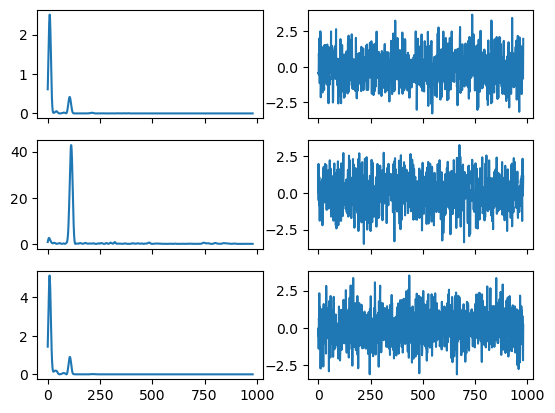

epoch 16
Epoch 17: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

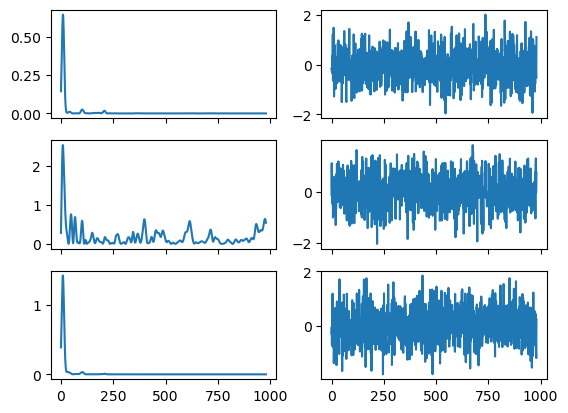

epoch 17
Epoch 18: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

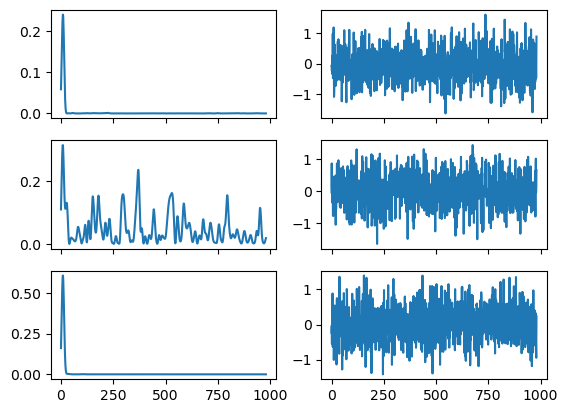

epoch 18
Epoch 19: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

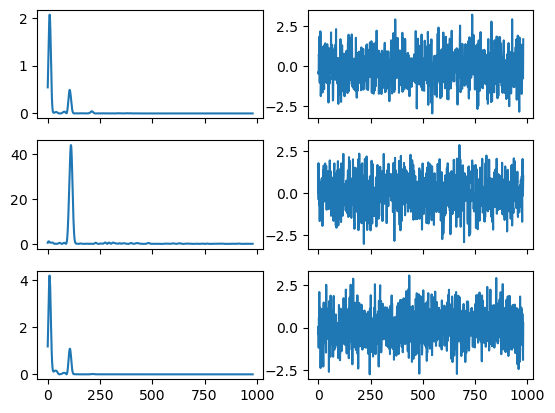

epoch 19
Epoch 20: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

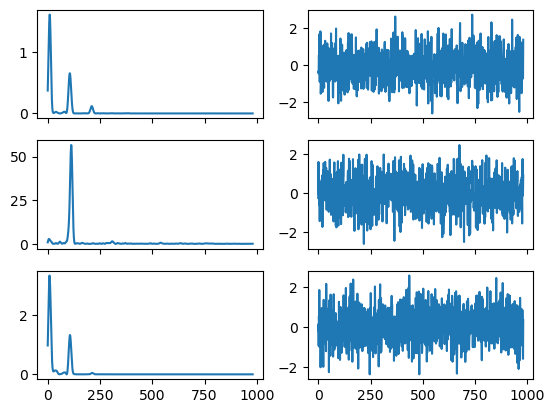

epoch 20
Epoch 21: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

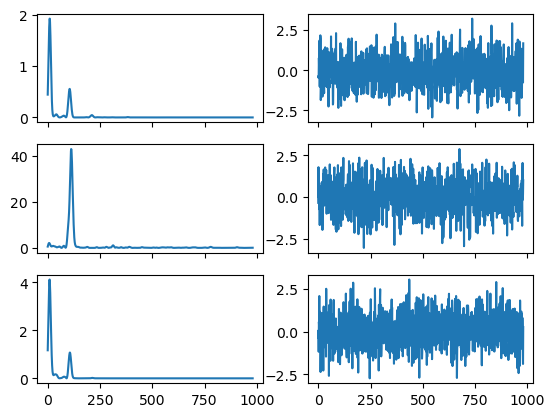

epoch 21
Epoch 22: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

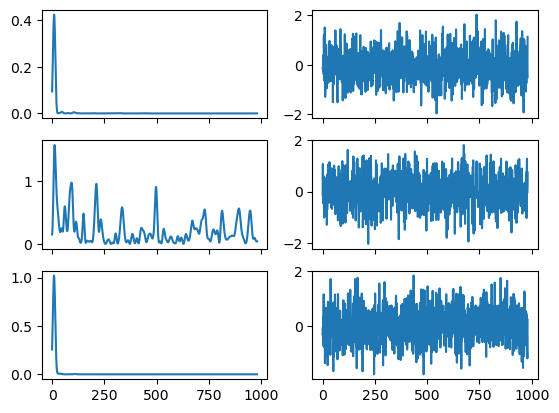

epoch 22
Epoch 23: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

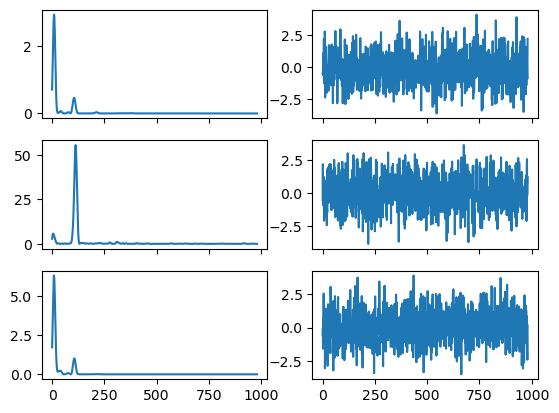

epoch 23
Epoch 24: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

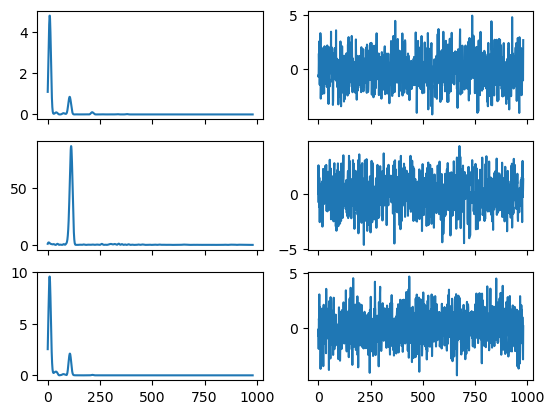

epoch 24
Epoch 25: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

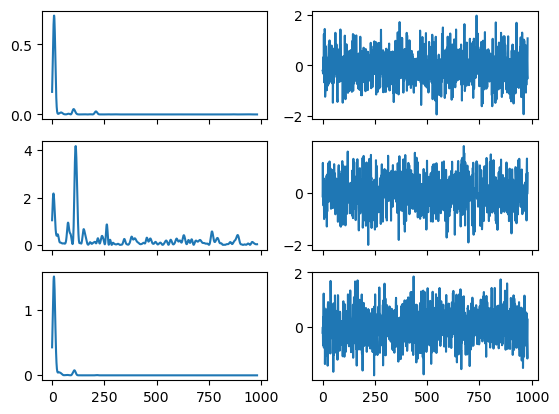

epoch 25
Epoch 26: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

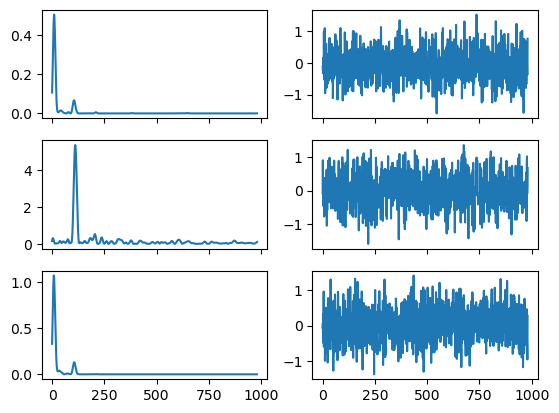

epoch 26
Epoch 27: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

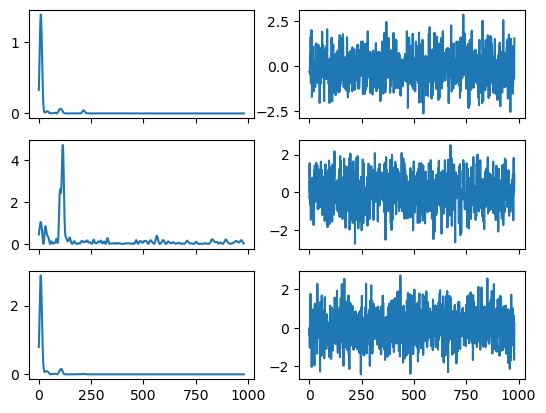

epoch 27
Epoch 28: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

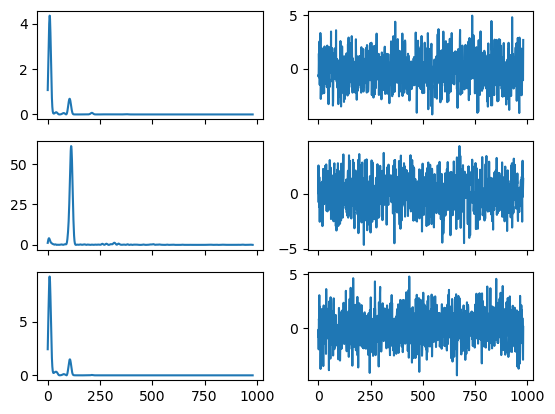

epoch 28
Epoch 29: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

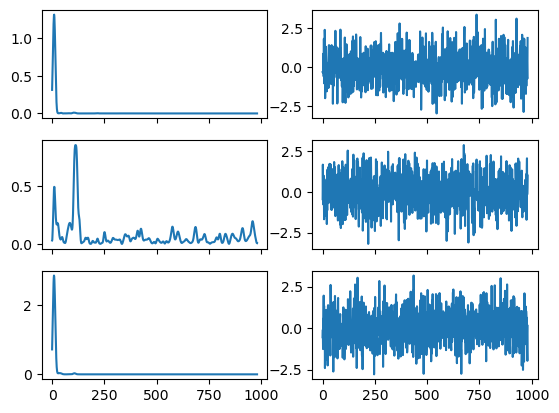

epoch 29
Epoch 30: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s, v_num=15]

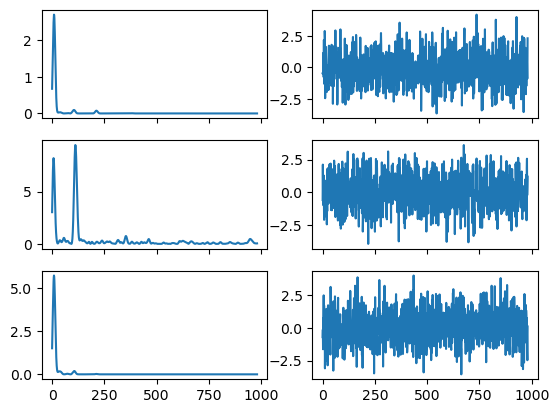

epoch 30
Epoch 31: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

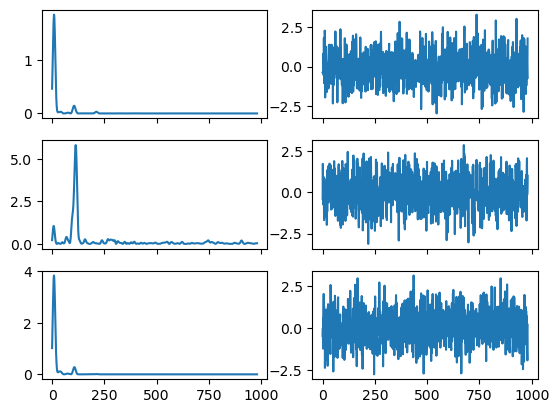

epoch 31
Epoch 32: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

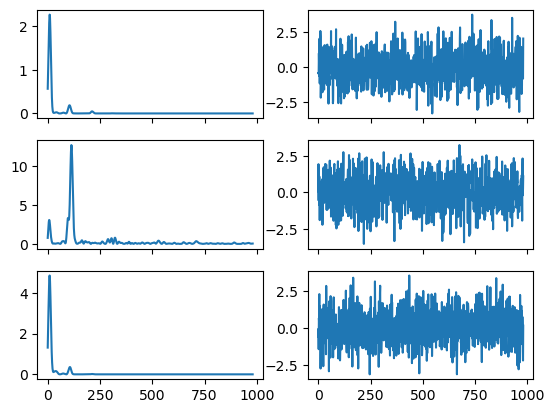

epoch 32
Epoch 33: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

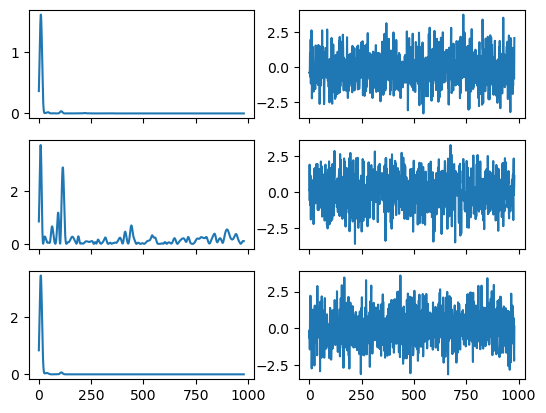

epoch 33
Epoch 34: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

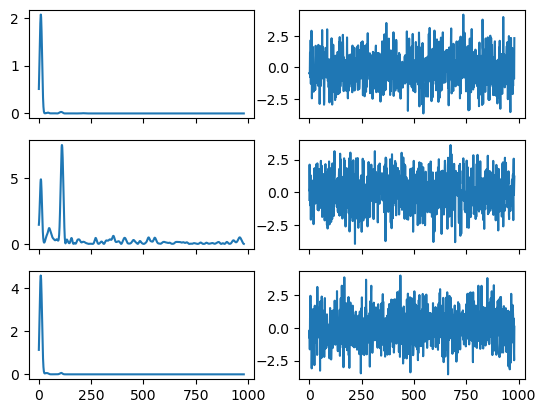

epoch 34
Epoch 35: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

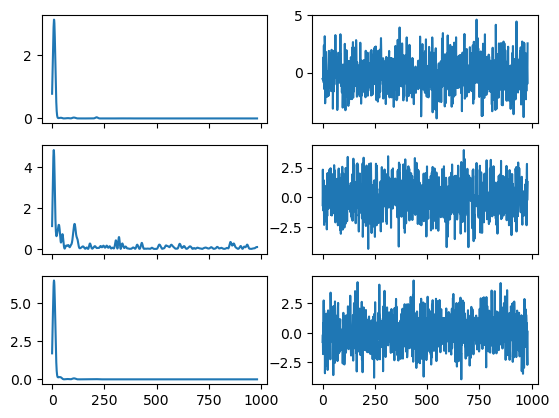

epoch 35
Epoch 36: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

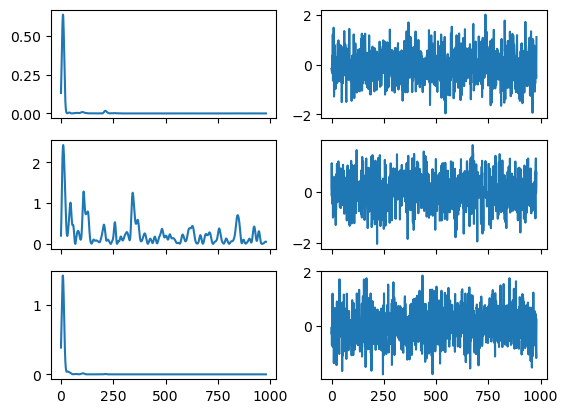

epoch 36
Epoch 37: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

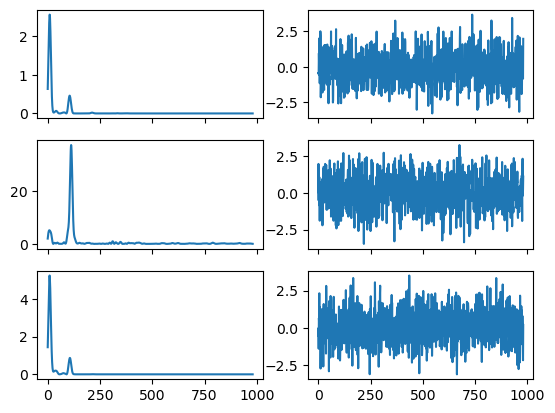

epoch 37
Epoch 38: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

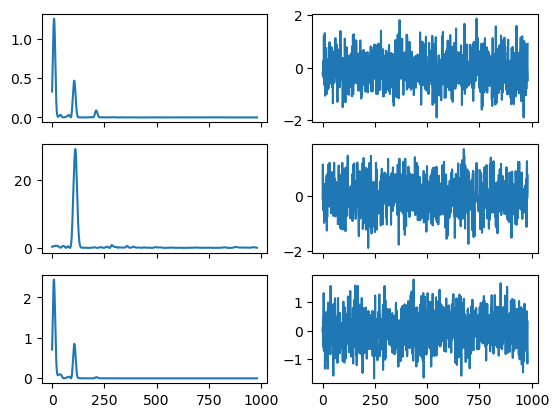

epoch 38
Epoch 39: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

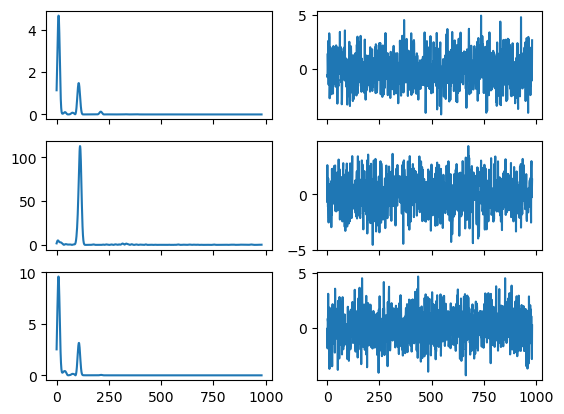

epoch 39
Epoch 40: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

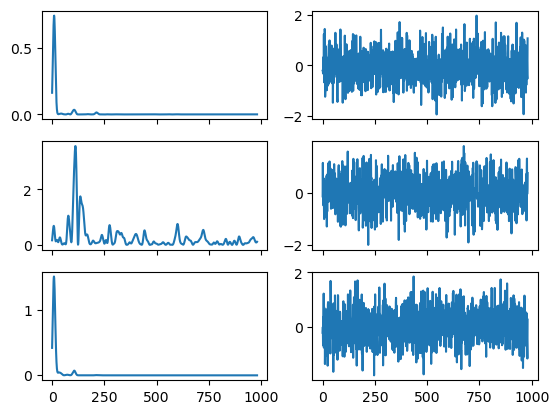

epoch 40
Epoch 41: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

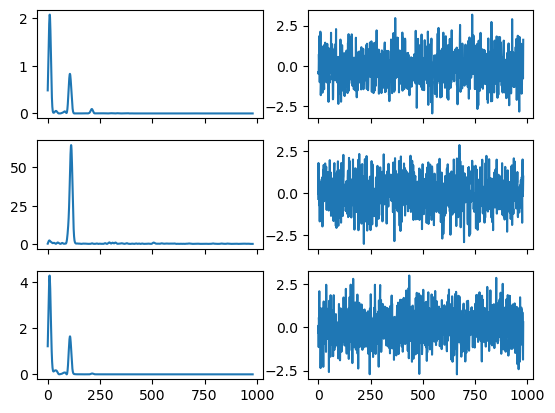

epoch 41
Epoch 42: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

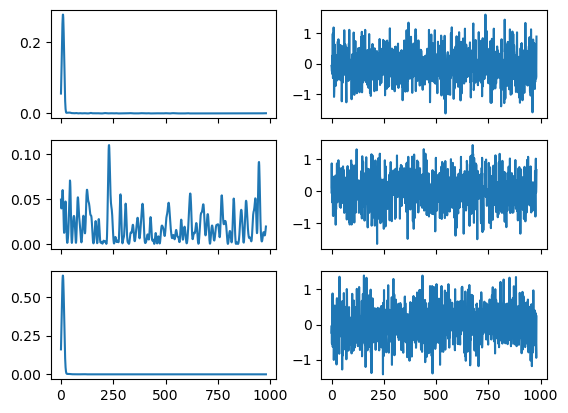

epoch 42
Epoch 43: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

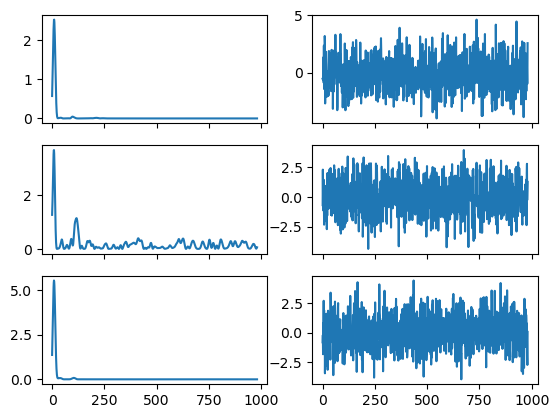

epoch 43
Epoch 44: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

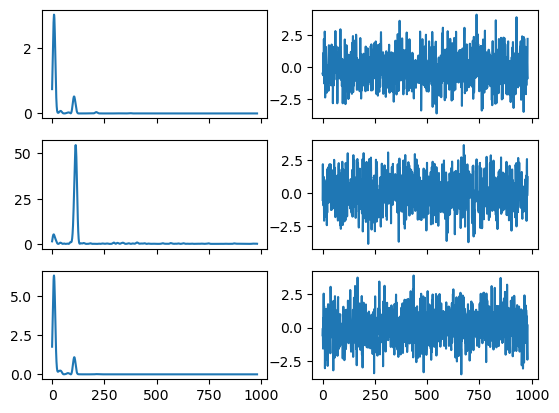

epoch 44
Epoch 45: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

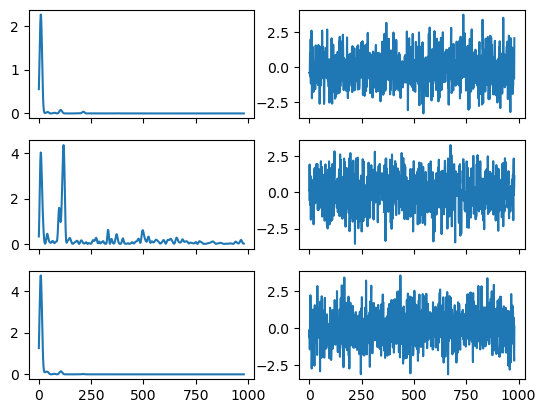

epoch 45
Epoch 46: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

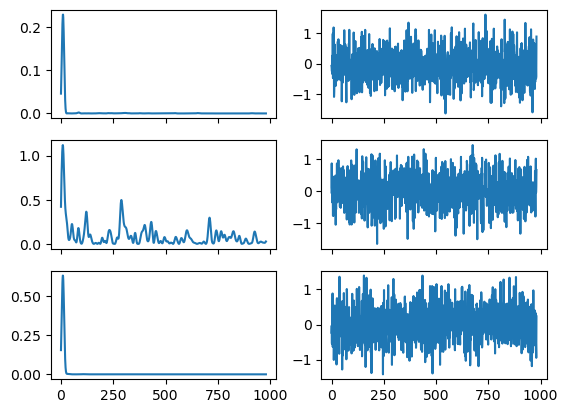

epoch 46
Epoch 47: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

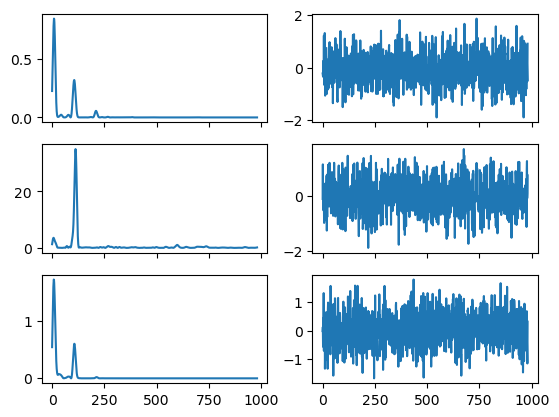

epoch 47
Epoch 48: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

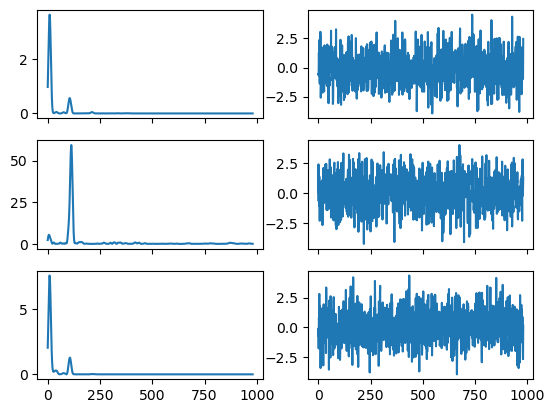

epoch 48
Epoch 49: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

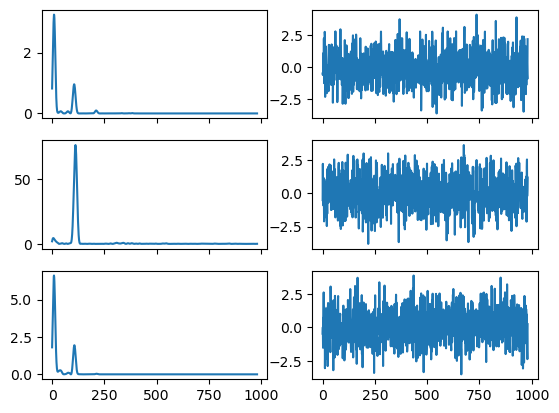

epoch 49
Epoch 50: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

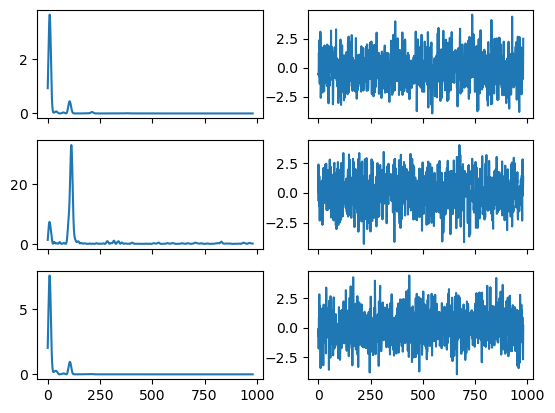

epoch 50
Epoch 51: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

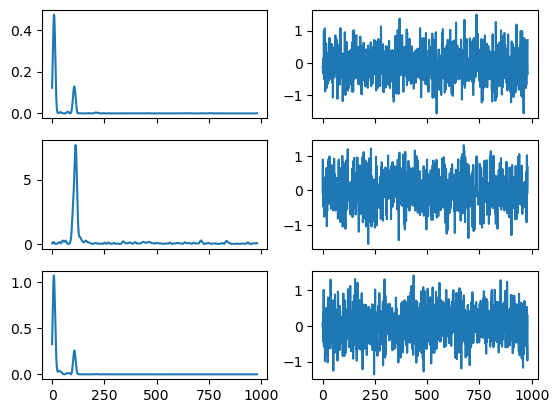

epoch 51
Epoch 52: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

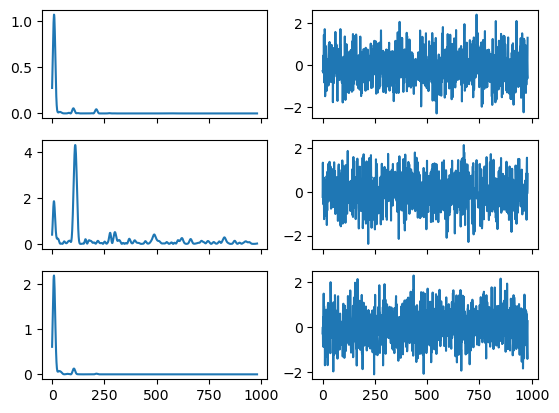

epoch 52
Epoch 53: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

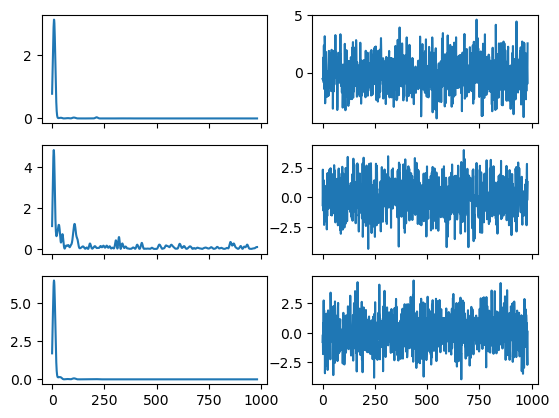

epoch 53
Epoch 54: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

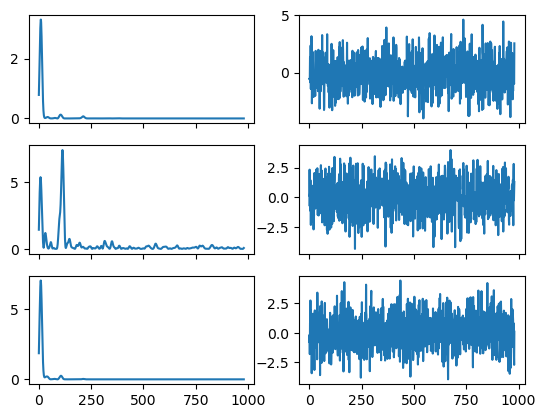

epoch 54
Epoch 55: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

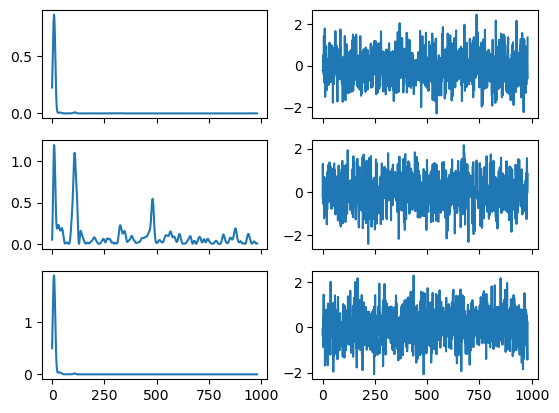

epoch 55
Epoch 56: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

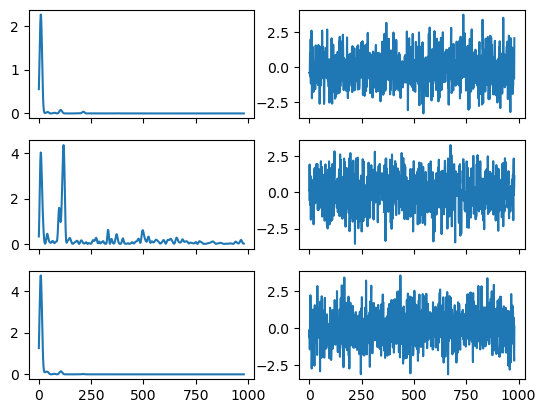

epoch 56
Epoch 57: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

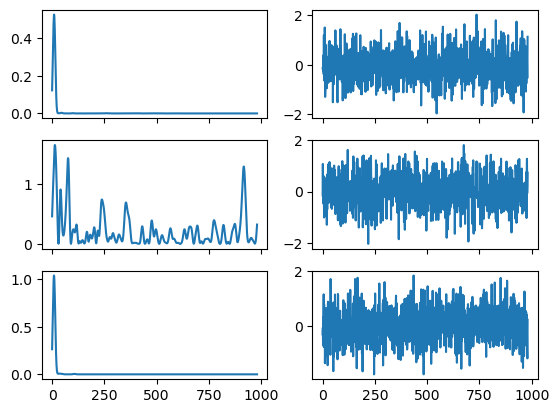

epoch 57
Epoch 58: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

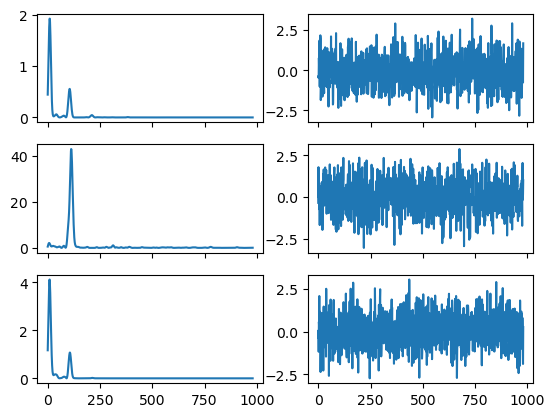

epoch 58
Epoch 59: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

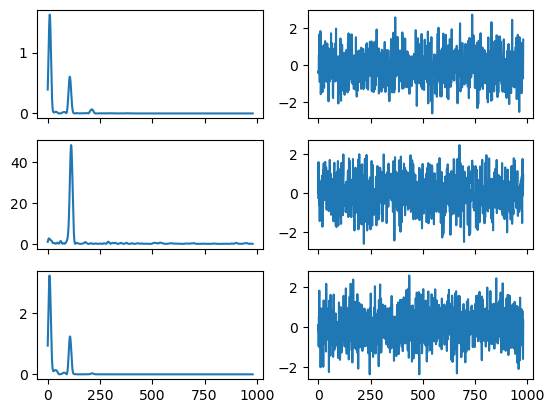

epoch 59
Epoch 60: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

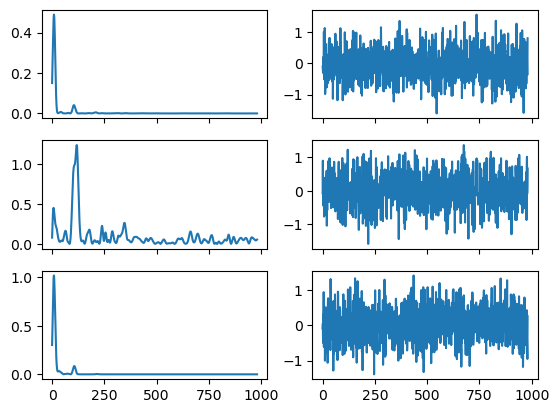

epoch 60
Epoch 61: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

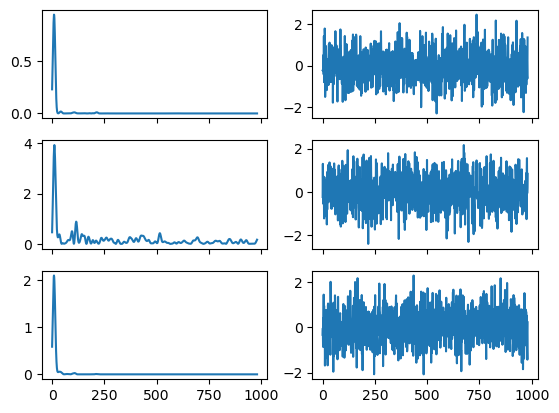

epoch 61
Epoch 62: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s, v_num=15]

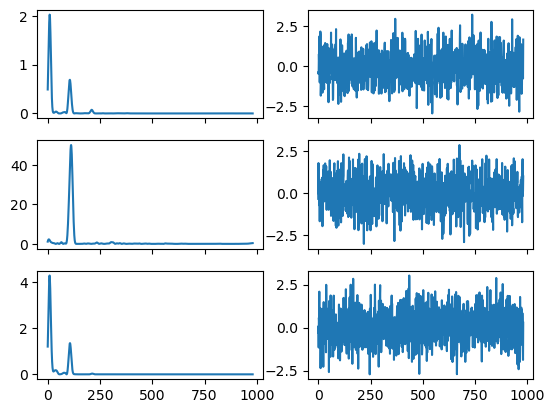

epoch 62
Epoch 63: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

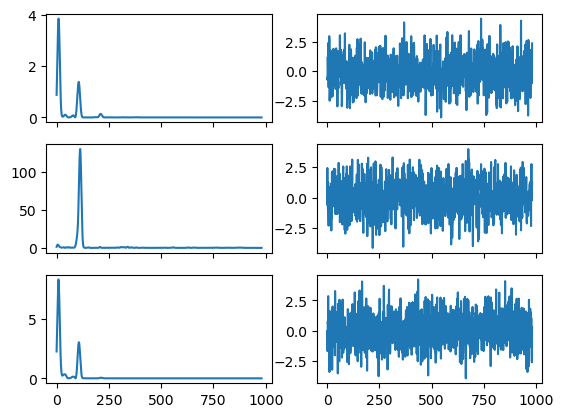

epoch 63
Epoch 64: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

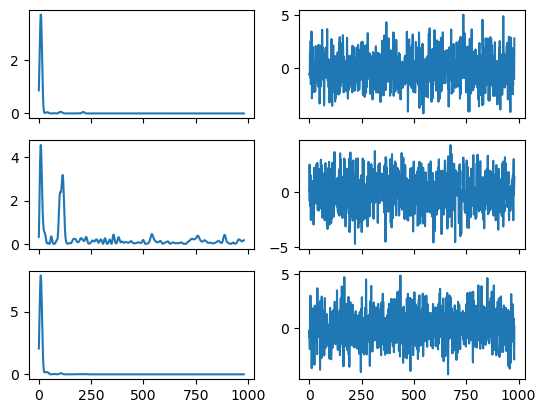

epoch 64
Epoch 65: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

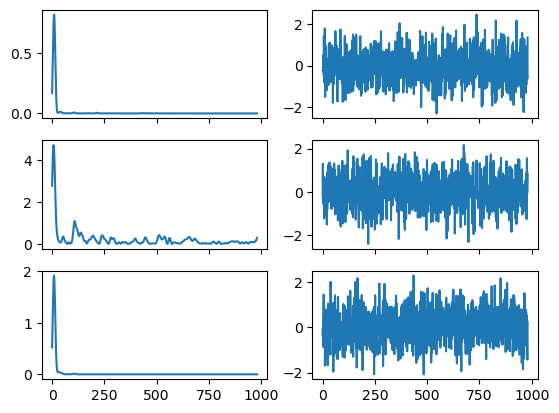

epoch 65
Epoch 66: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

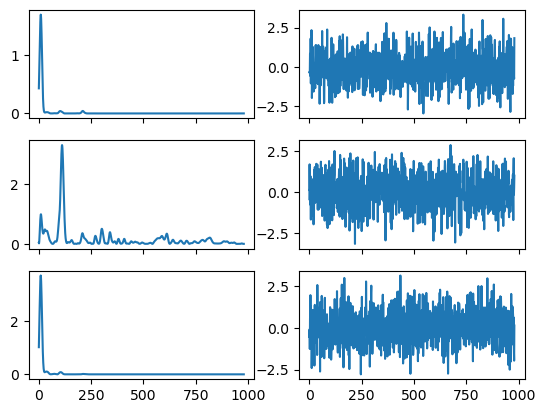

epoch 66
Epoch 67: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

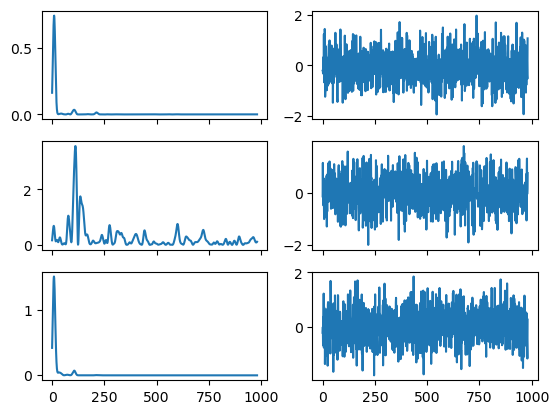

epoch 67
Epoch 68: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

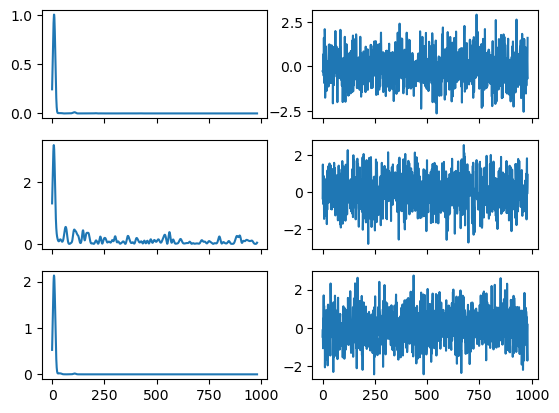

epoch 68
Epoch 69: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

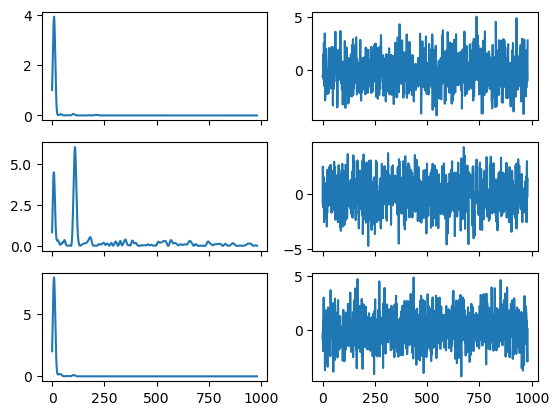

epoch 69
Epoch 70: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

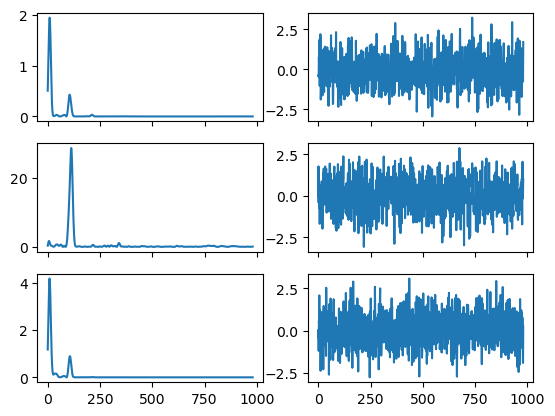

epoch 70
Epoch 71: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

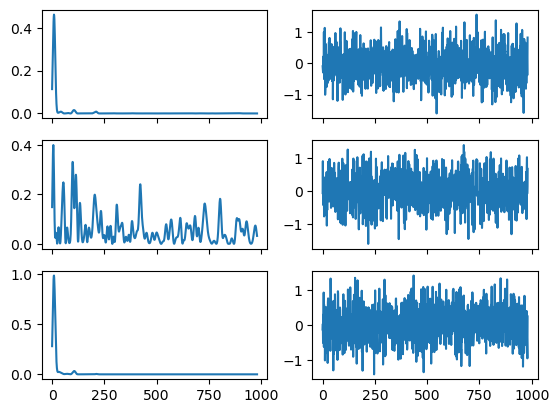

epoch 71
Epoch 72: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

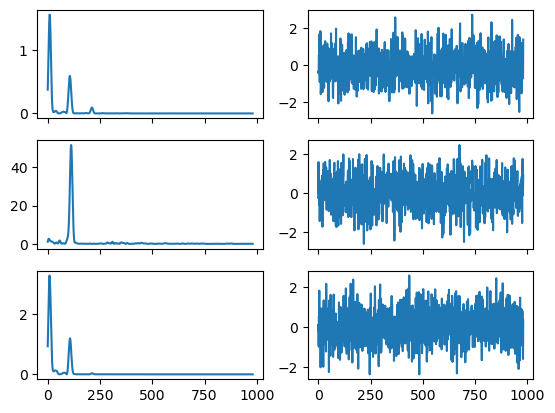

epoch 72
Epoch 73: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

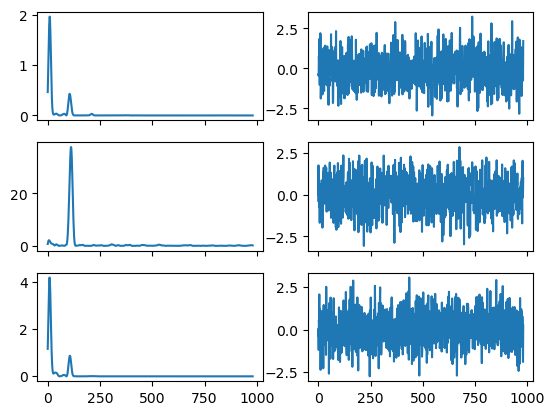

epoch 73
Epoch 74: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

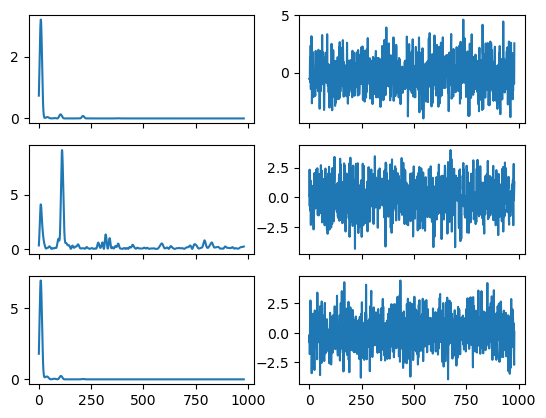

epoch 74
Epoch 75: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

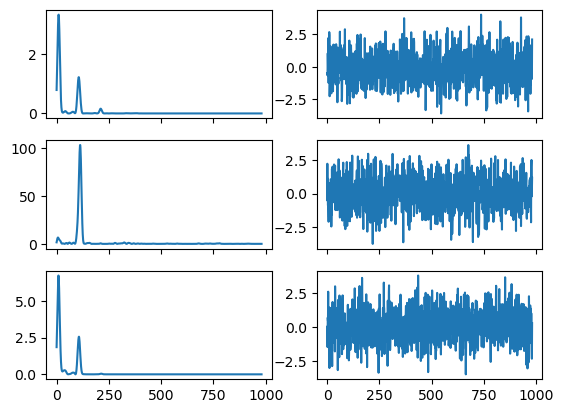

epoch 75
Epoch 76: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s, v_num=15]

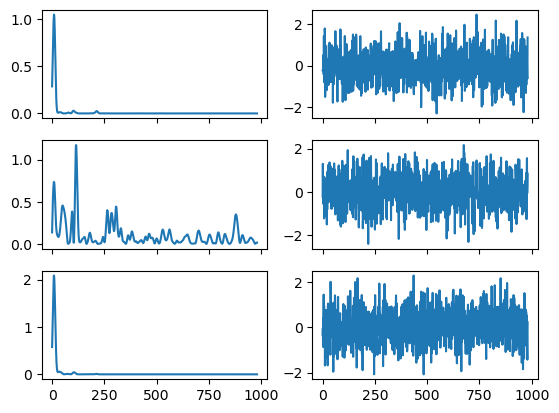

epoch 76
Epoch 77: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

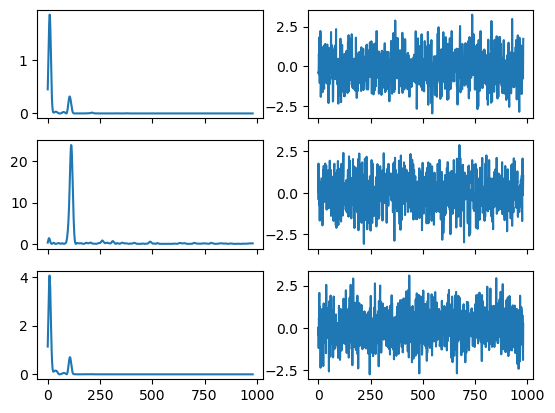

epoch 77
Epoch 78: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

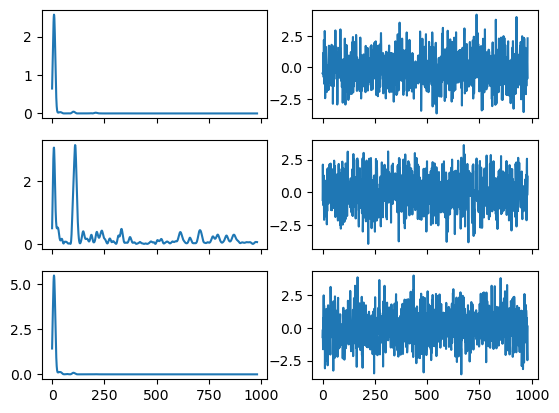

epoch 78
Epoch 79: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

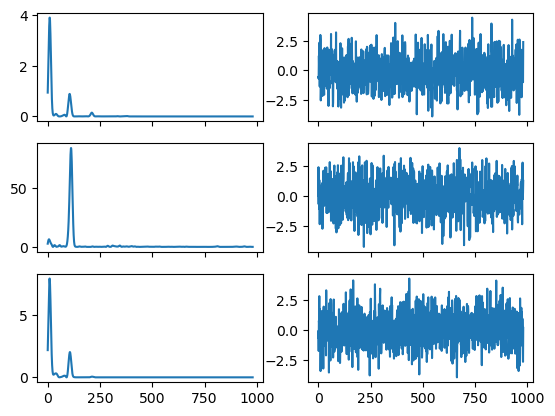

epoch 79
Epoch 80: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

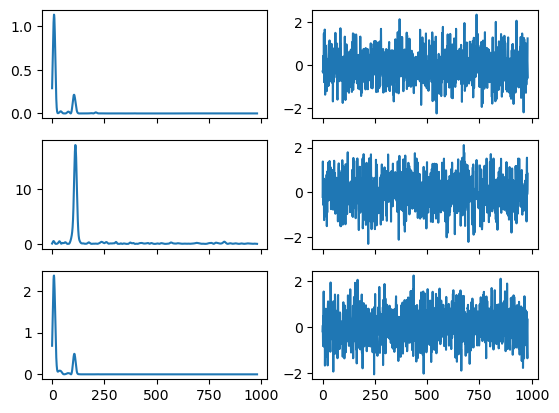

epoch 80
Epoch 81: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

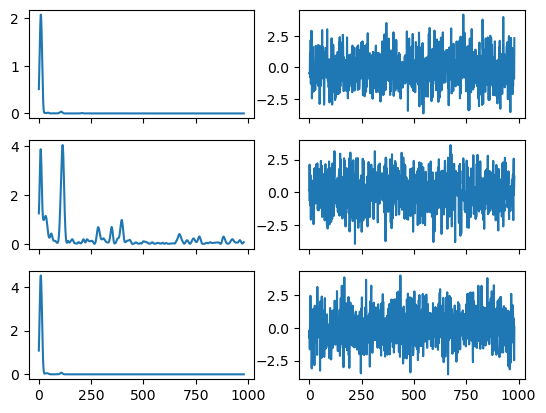

epoch 81
Epoch 82: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

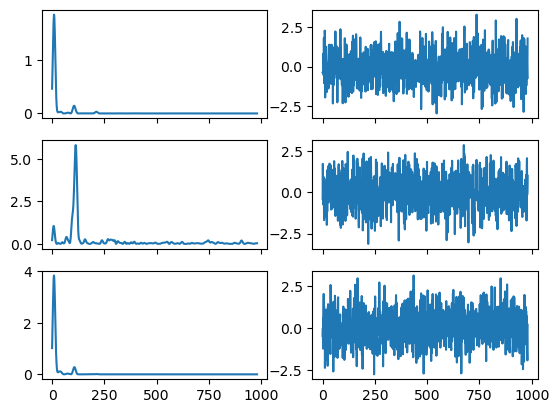

epoch 82
Epoch 83: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

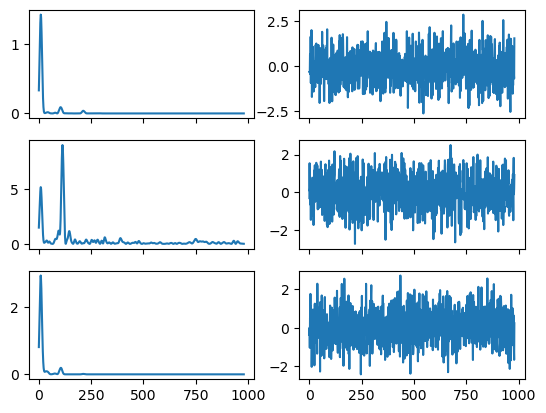

epoch 83
Epoch 84: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

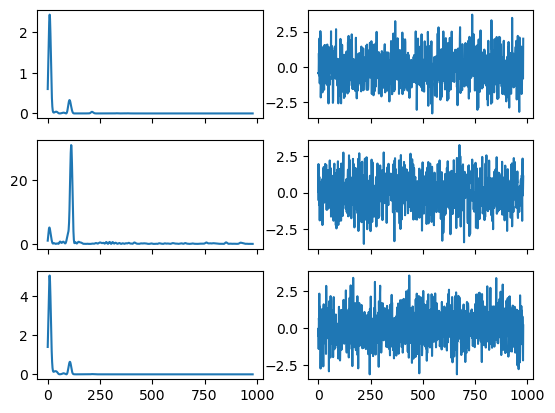

epoch 84
Epoch 85: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

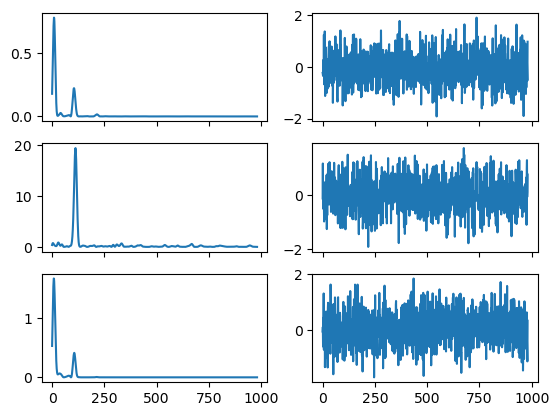

epoch 85
Epoch 86: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

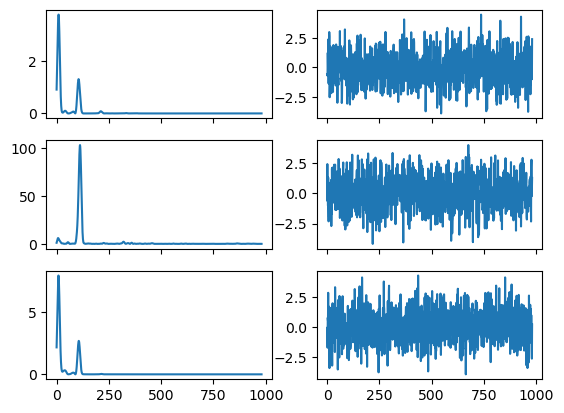

epoch 86
Epoch 87: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

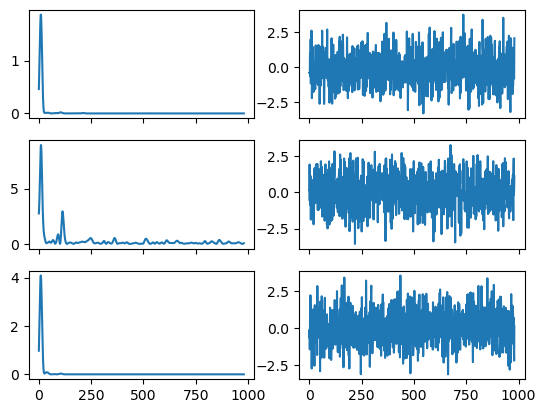

epoch 87
Epoch 88: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

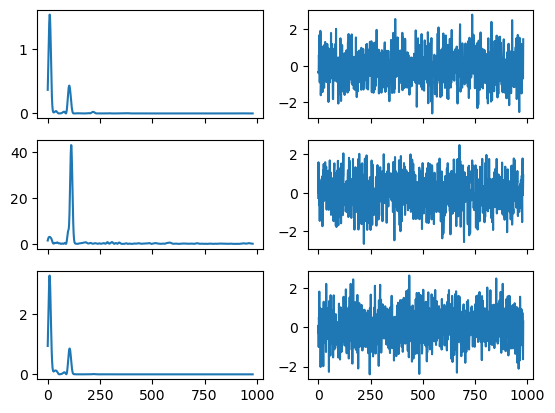

epoch 88
Epoch 89: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

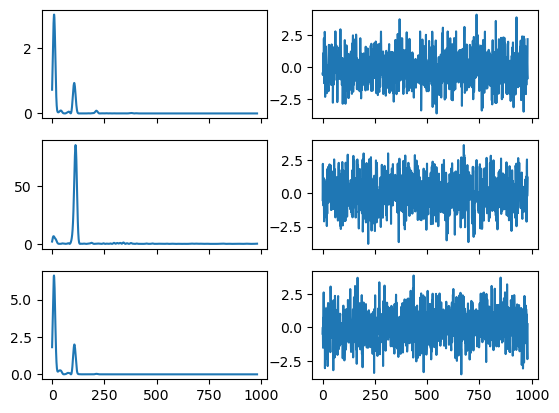

epoch 89
Epoch 90: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

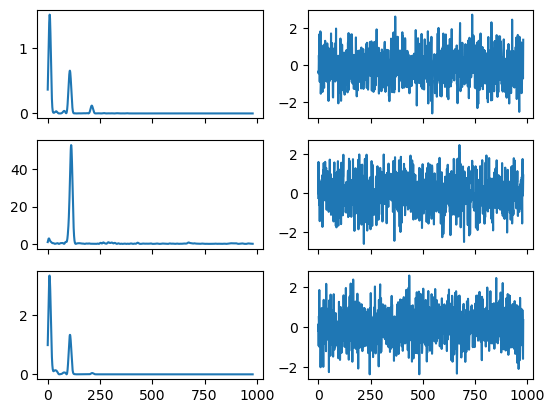

epoch 90
Epoch 91: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

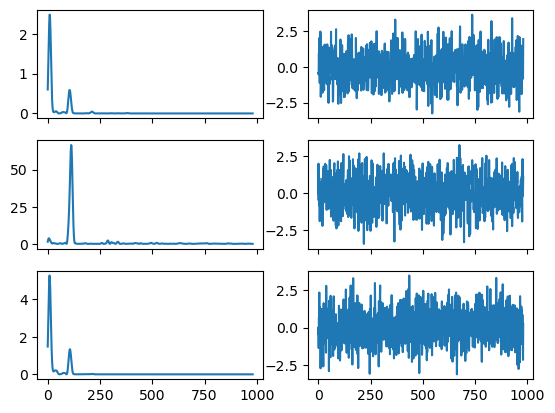

epoch 91
Epoch 92: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

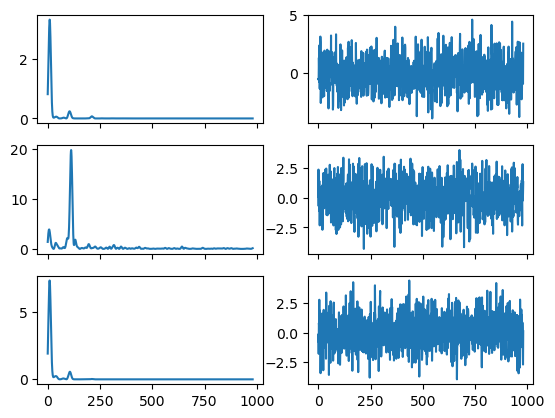

epoch 92
Epoch 93: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

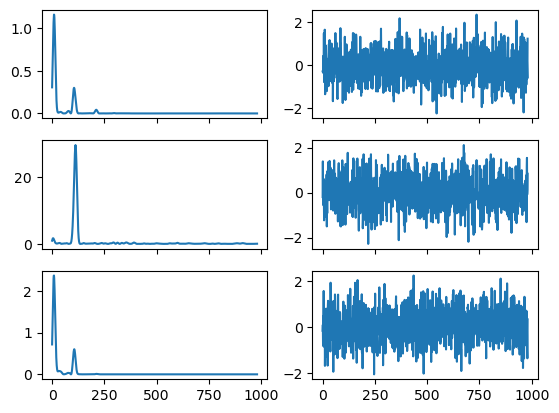

epoch 93
Epoch 94: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

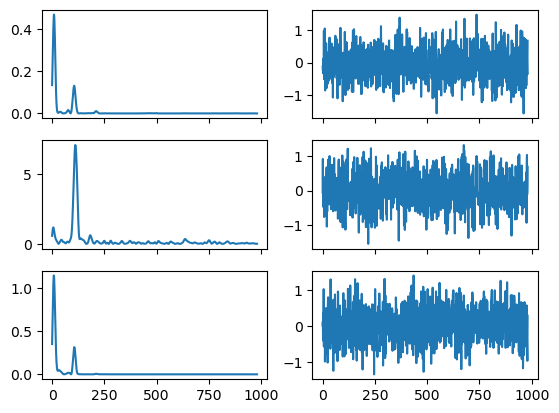

epoch 94
Epoch 95: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

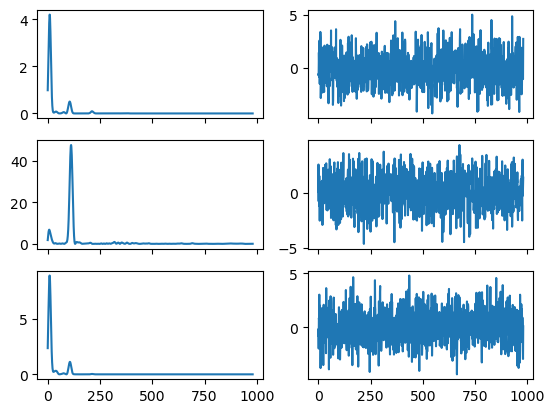

epoch 95
Epoch 96: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

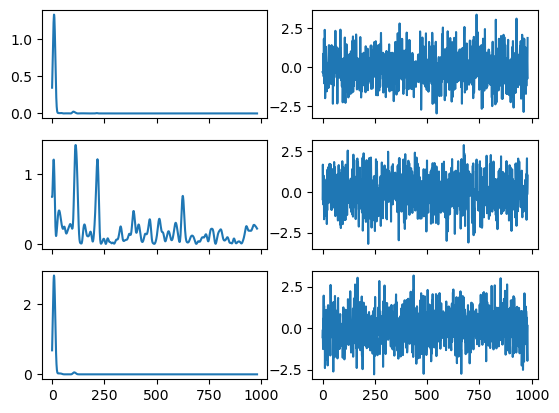

epoch 96
Epoch 97: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

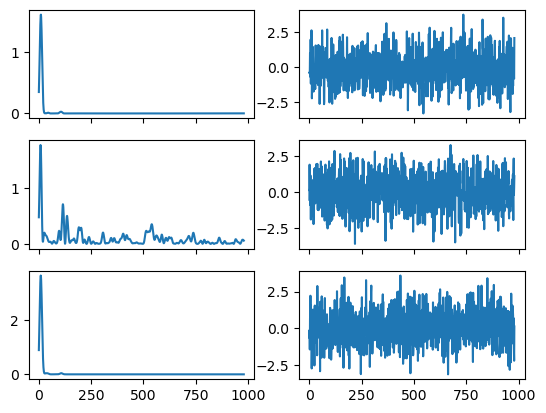

epoch 97
Epoch 98: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

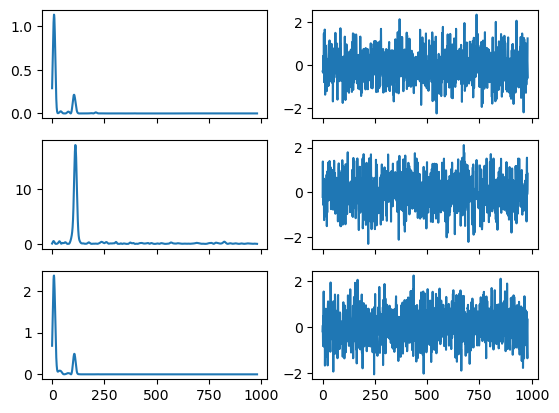

epoch 98
Epoch 99: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

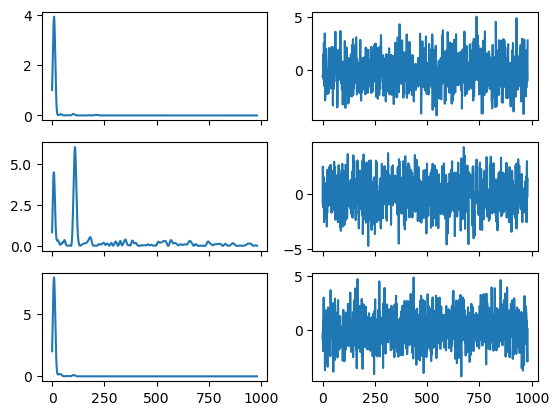

epoch 99
Epoch 100: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

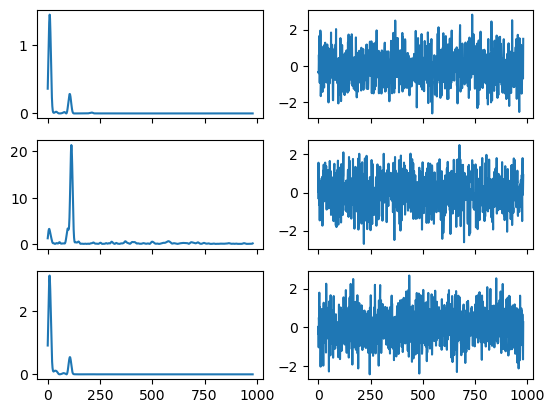

epoch 100
Epoch 101: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

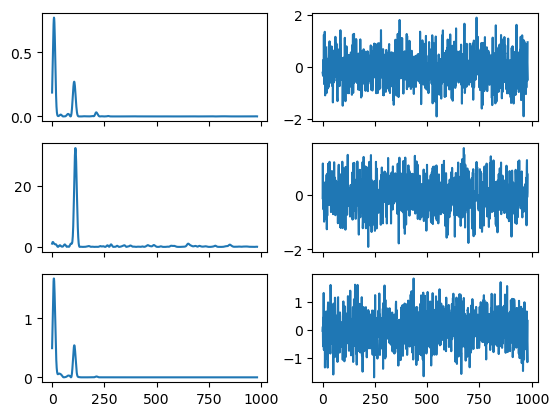

epoch 101
Epoch 102: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

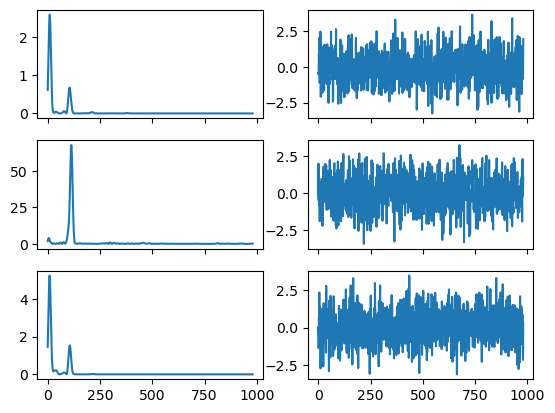

epoch 102
Epoch 103: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

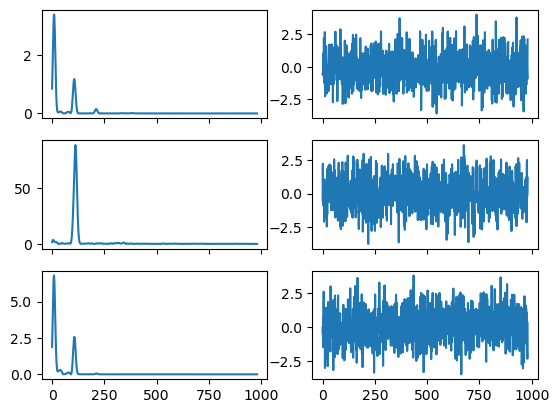

epoch 103
Epoch 104: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

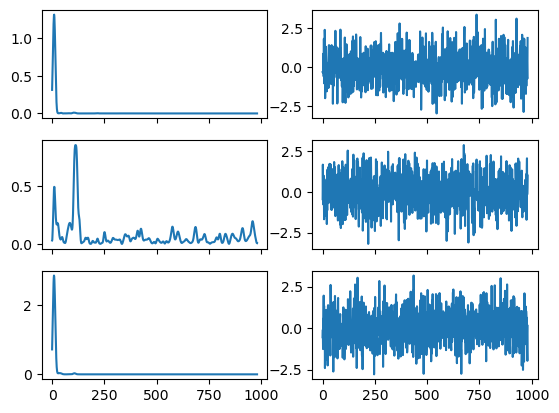

epoch 104
Epoch 105: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

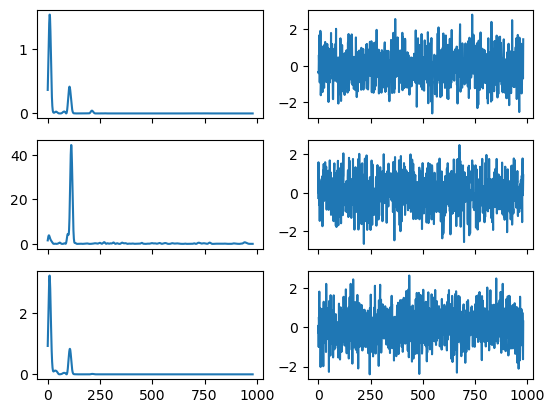

epoch 105
Epoch 106: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

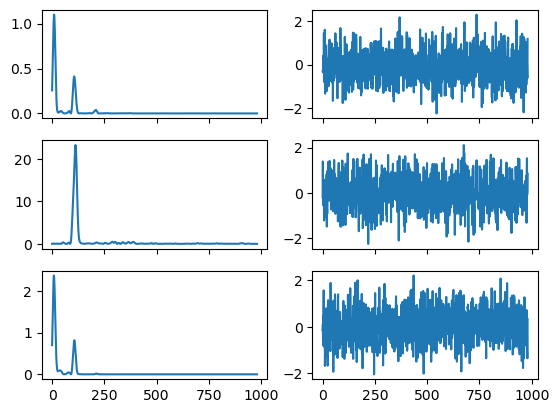

epoch 106
Epoch 107: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

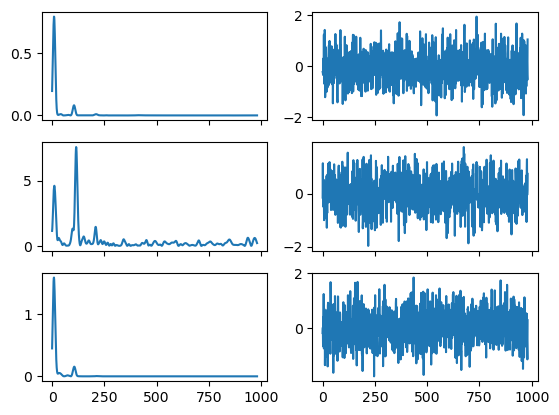

epoch 107
Epoch 108: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

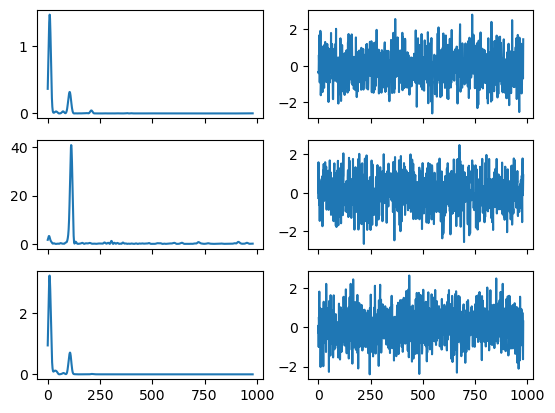

epoch 108
Epoch 109: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

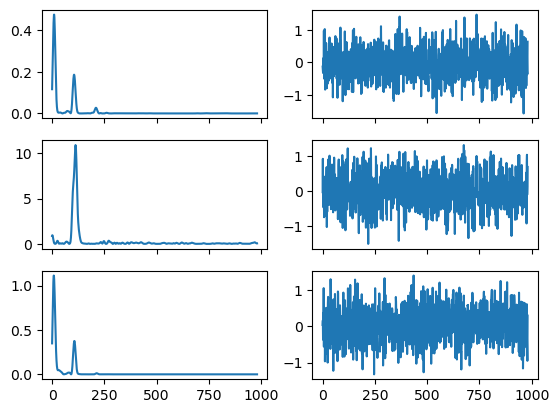

epoch 109
Epoch 110: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

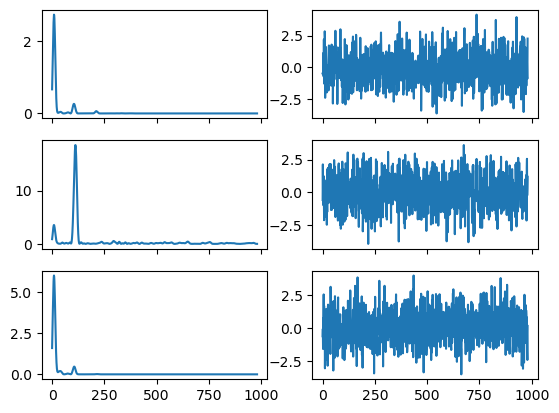

epoch 110
Epoch 111: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

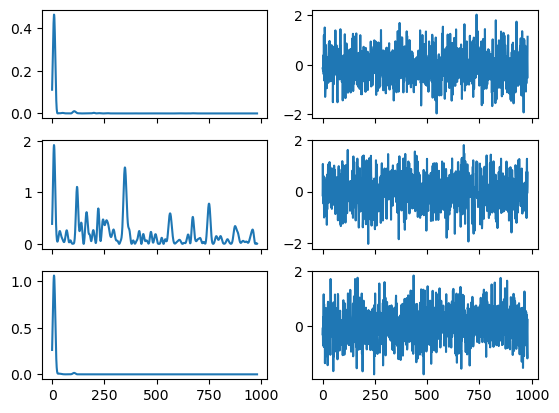

epoch 111
Epoch 112: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

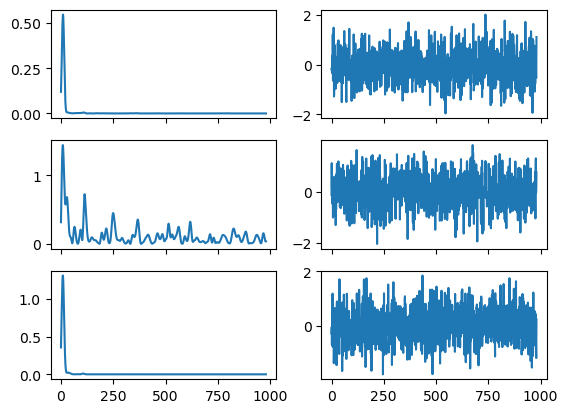

epoch 112
Epoch 113: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

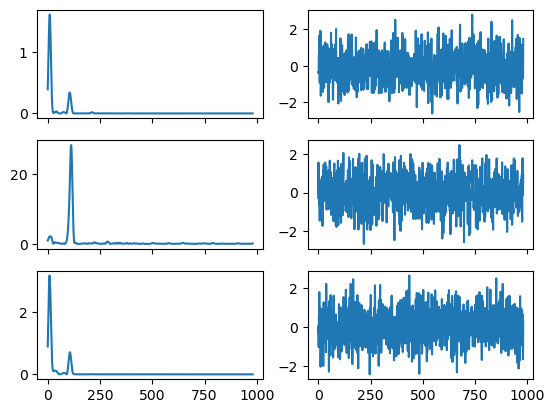

epoch 113
Epoch 114: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

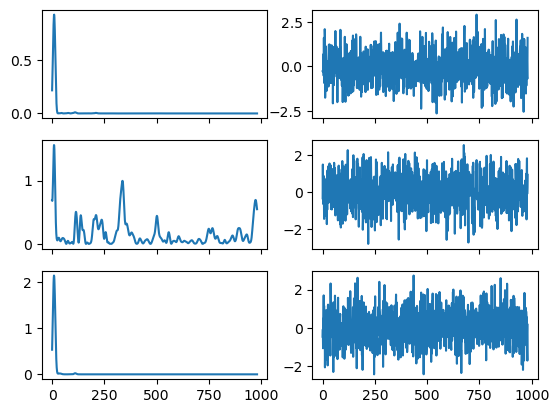

epoch 114
Epoch 115: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

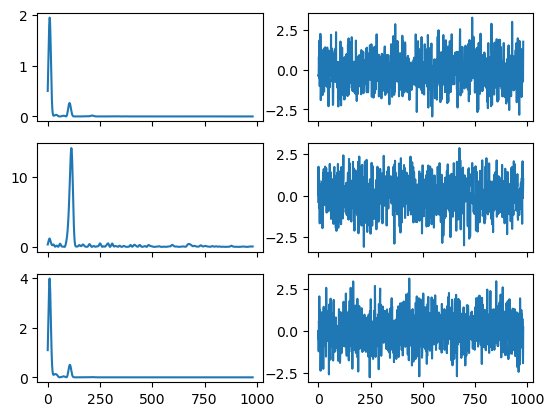

epoch 115
Epoch 116: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

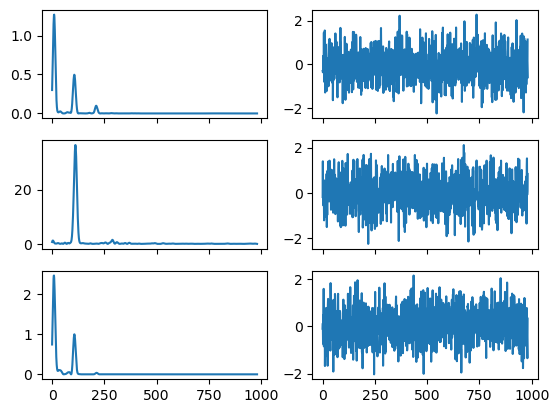

epoch 116
Epoch 117: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

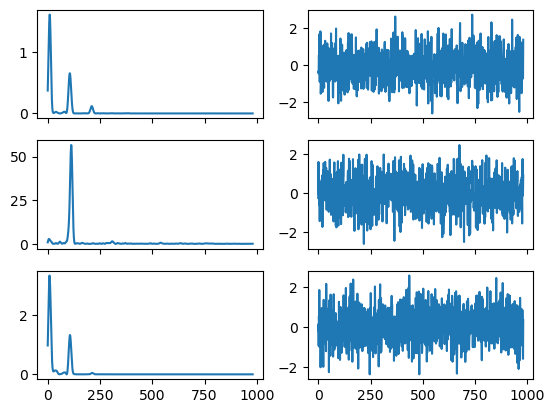

epoch 117
Epoch 118: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

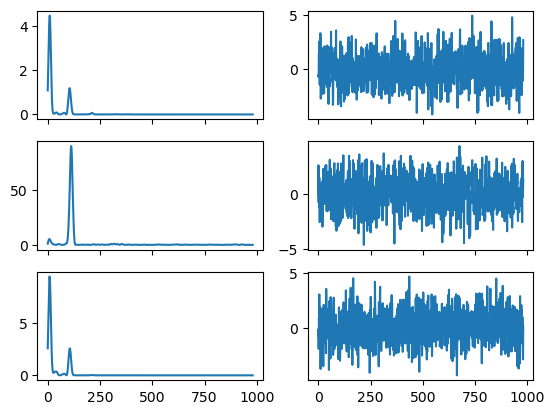

epoch 118
Epoch 119: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

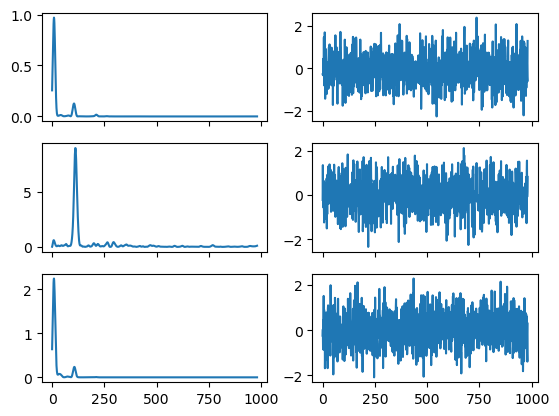

epoch 119
Epoch 120: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

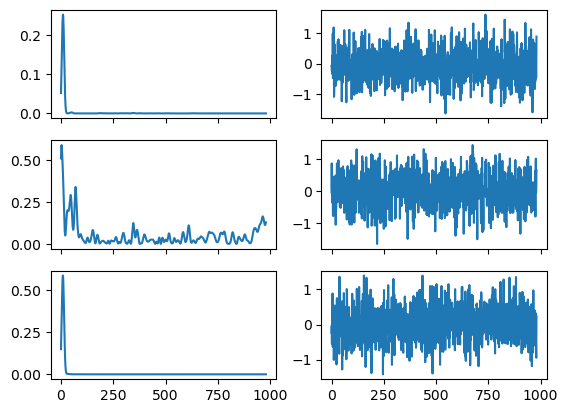

epoch 120
Epoch 121: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

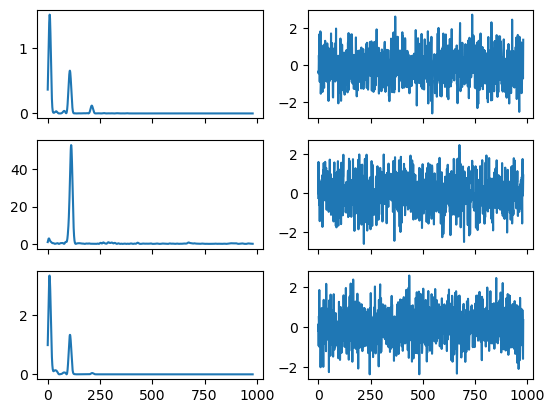

epoch 121
Epoch 122: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

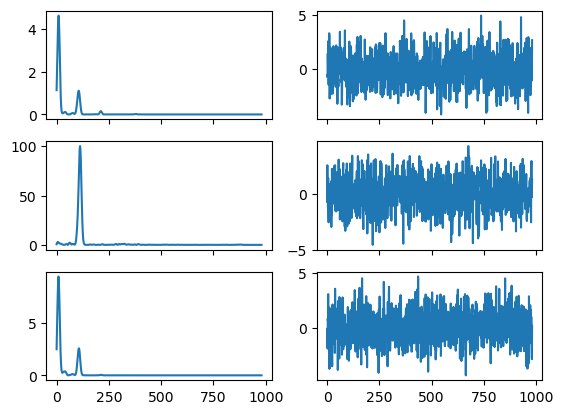

epoch 122
Epoch 123: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

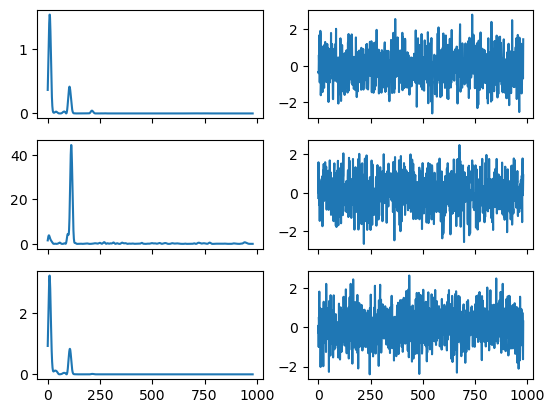

epoch 123
Epoch 124: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

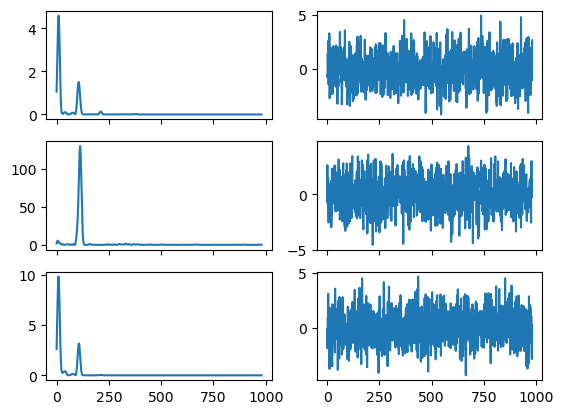

epoch 124
Epoch 125: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

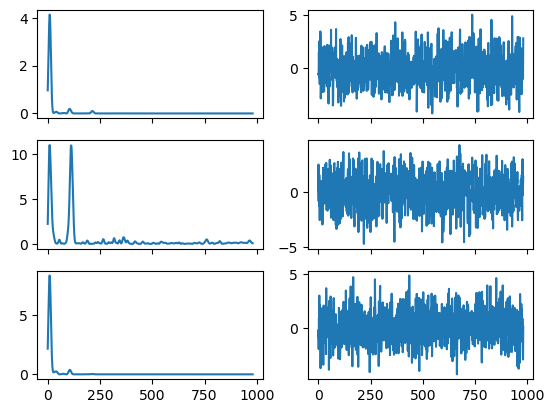

epoch 125
Epoch 126: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

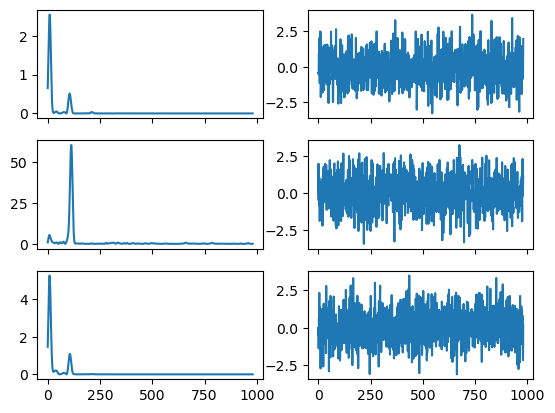

epoch 126
Epoch 127: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

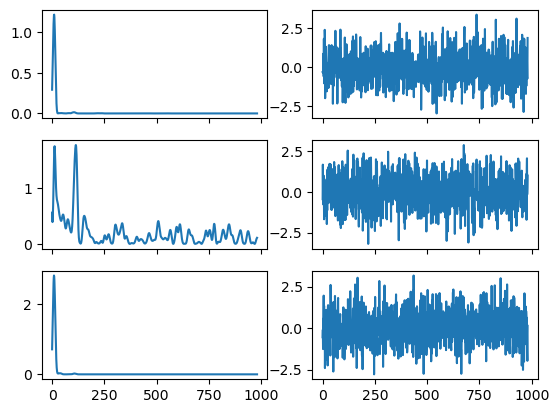

epoch 127
Epoch 128: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

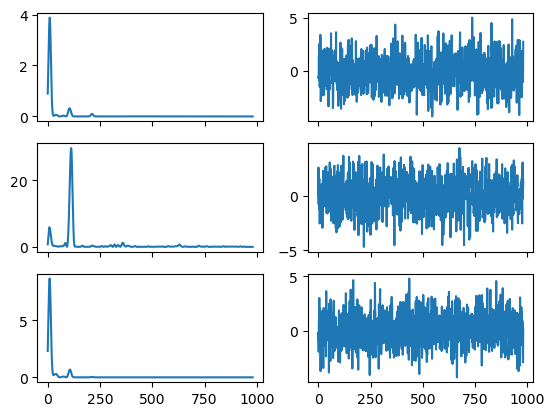

epoch 128
Epoch 129: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

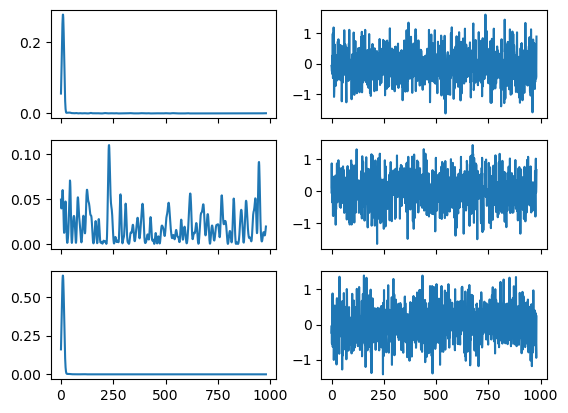

epoch 129
Epoch 130: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, v_num=15]

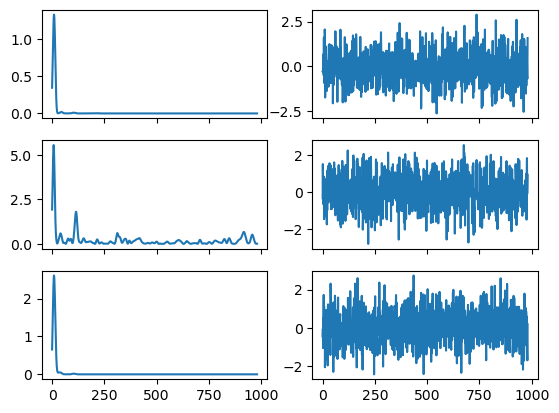

epoch 130
Epoch 131: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s, v_num=15]

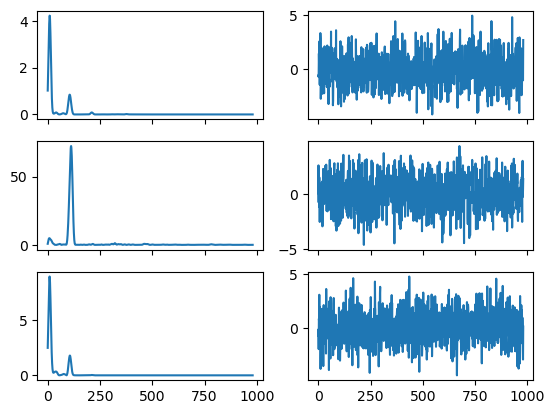

epoch 131
Epoch 132: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

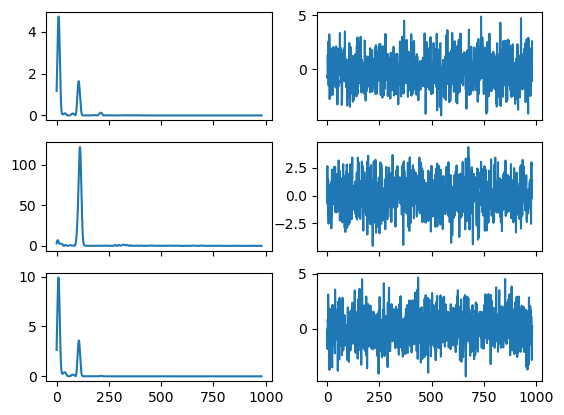

epoch 132
Epoch 133: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

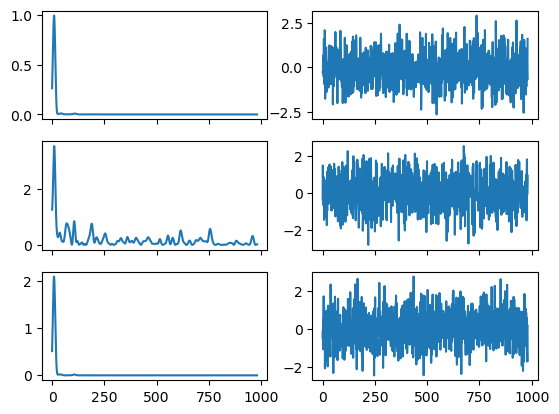

epoch 133
Epoch 134: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

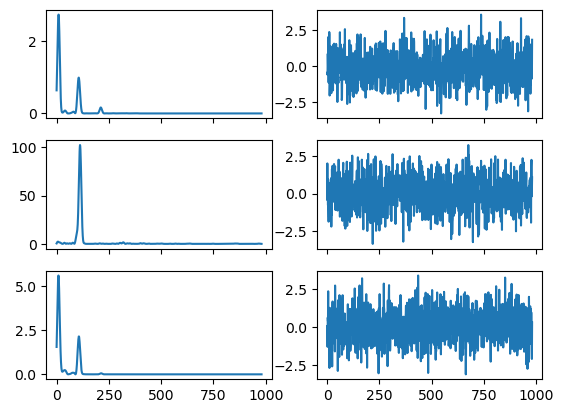

epoch 134
Epoch 135: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

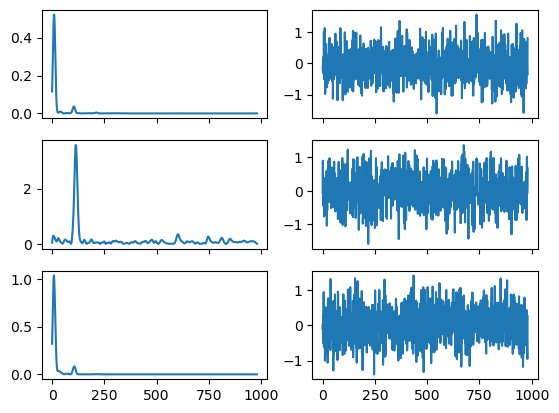

epoch 135
Epoch 136: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, v_num=15]

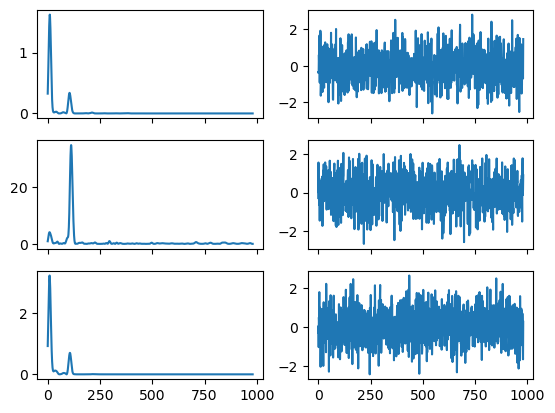

epoch 136
Epoch 137: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

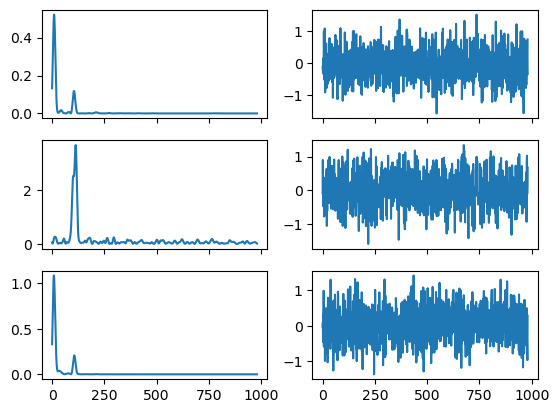

epoch 137
Epoch 138: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s, v_num=15]

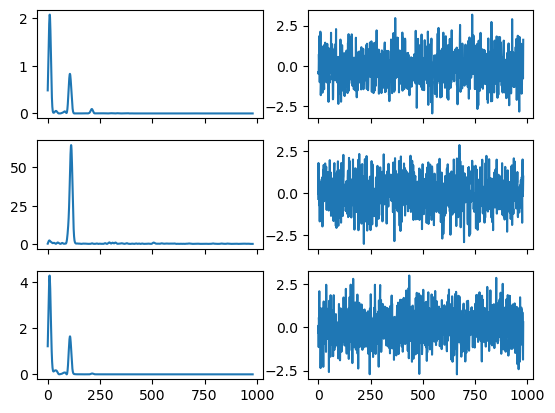

epoch 138
Epoch 139: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, v_num=15]

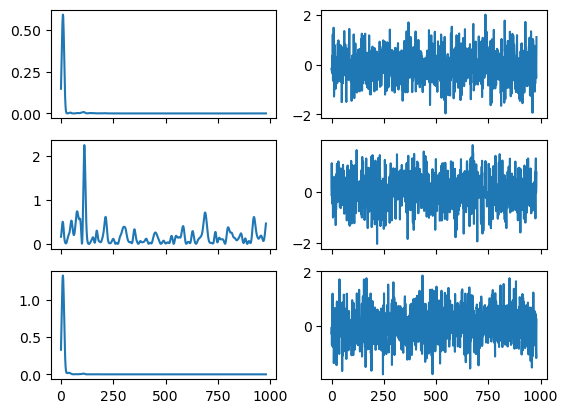

epoch 139
Epoch 140: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s, v_num=15]

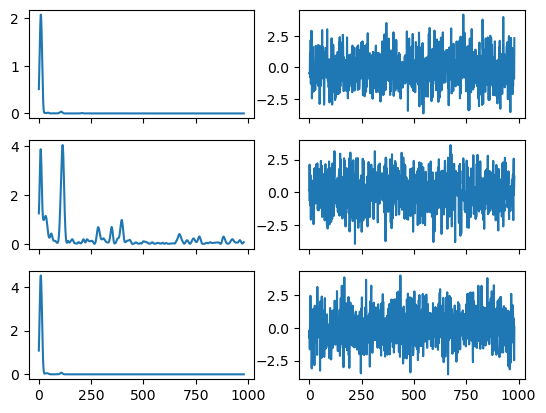

epoch 140
Epoch 141: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s, v_num=15]

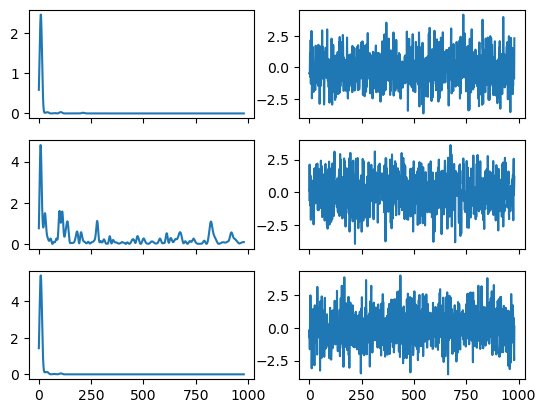

epoch 141
Epoch 142:  53%|█████▎    | 8/15 [00:04<00:04,  1.68it/s, v_num=15] 

c:\Users\SMEET_SIMUL\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [67]:
trainer.fit(model,data_module)